## Quantifying Clinical Gaps in Valvular Heart Disease: Using the Medication Burden Index (MBI) to Triage High-Complexity Surgical Candidates.

### 1. Project Manifesto & Data Context
---

This project analyzes real-world clinical data from a high-volume medical mission in León, Nicaragua. The brigade operates via a structured, three-phase clinical workflow designed to bridge the gap between primary screening and advanced cardiac intervention:

* **Phase 1 — General Cardiology Clinic:** High-throughput diagnostic screening, echocardiographic evaluation, and procedure prioritization.

* **Phase 2 — Electrophysiology:** Arrhythmia management, including cardiac ablations and permanent pacemaker/ICD implantation.

* **Phase 3 — Interventional Cardiology:** Percutaneous structural heart procedures and collaborative case reviews.

#### The Dataset and population: 

he analysis focuses on the Phase 1 - 2025 Cohort. To ensure clinical relevance and focus on adult structural heart disease, the population was filtered as follows:
* **Initial Enrollment:** $N=187$ patients.

* **Exclusion Criteria:** Patients $< 15$ years old or those with entirely normal echocardiographic findings (no disease criteria met).

* **Final Analytical Sample:** $N=152$ patients.

#### The Problem: The "Silence of the Normal" (MNAR bias)

In a 10-day clinical sprint, data is recorded on physical paper charts at the bedside and retrospectively digitized into Notion and Excel. This workflow creates a specific form of bias: Missing Not At Random (MNAR).

In high-volume brigade settings, "Missingness" is a clinical surrogate for "Normal." A cardiologist under extreme time pressure will prioritize documenting a pathological $1.2 cm^{2}$ Mitral Valve area but will likely leave the Aortic Valve field blank if it appears healthy. Standard imputation (mean/median) would erroneously assign "diseased" values to these healthy valves, leading to Model Alarmism and an overestimation of cohort severity.

#### The Strategy: "Natural Normal" Imputation

To preserve the statistical integrity of the cohort and prevent pathology bias, we utilize a **Natural Normal Imputation** strategy. Instead of treating nulls as errors, we treat them as "Healthy Proxies" and inject physiological noise to simulate a realistic population distribution.

**The Technique:** We apply Gaussian noise centered around healthy clinical constants:

$$X_{imp} \sim \mathcal{N}(\mu_{healthy}, \sigma^{2}_{phys})$$

*Example:* For a missing Right Ventricular Systolic Pressure (RVSP), we assume a "normal" physiological state. Rather than imputing the cohort mean (which may be elevated due to severe mitral disease), we impute values centered around $25\text{ mmHg}$ with a small standard deviation ($\sigma \approx 4\text{ mmHg}$). This reflects a healthy pulmonary pressure range of $19\text{--}31\text{ mmHg}$.

#### The Goal: Clinical Baseline Preservation

By creating this "Natural Normal" baseline, we prevent the model from being skewed by the sickest group of patients. This allows for a more robust comparison of disease burden and ensures our Medication Burden Index (MBI) accurately reflects the clinical complexity of the surgical candidates.

In [2]:
# 1. IMPORTS
# ==========================================

# %matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display, Markdown, HTML
import re
import missingno as msno
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os

### 2. The Clinical Knowledge Base (The "Medical Brain")
---

To ensure the reproducibility and clinical validity of this pipeline, I have implemented a **Centralized Configuration Object**. In a real-world healthcare setting, separating clinical logic from processing code is vital—it allows medical directors to audit the criteria without needing to parse complex data engineering logic.

This class encapsulates:

* **Anatomic Groupings:** Organizing echo parameters by valve (Mitral vs. Aortic).

* **Pharmacological Mapping:** Cataloging max doses and clinical weights for the Medication Burden Index (MBI).

* **Heuristic Logic:** Regex patterns for extracting diagnoses from messy clinical notes.

* **Physiological Baselines:** Defining the $\mu$ and $\sigma$ for the Natural Normal Imputation.

In [3]:
# 2. DICTIONARIES AND LISTS
# ==========================================

# * These dictionaries and lists act as the "Medical Brain" of the script. 

# Separating logic from data allows non-coders to update clinical criteria easily.
class ClinicalConfig:
    """
    Centralized configuration object acting as the 'Medical Brain'.
    Encapsulates all clinical dictionaries, regex patterns, decision boundaries,
    and biological sanity checks.
    """
    def __init__(self):
        # 1. Variable Categorization to be selected for the dataframe
        self.categories = {
            "Demographics/Vitals": ['ID', 'Age', 'Gender', 'Weight', 'OSat', 'SBP R', 'DBP R', 'Heart rate'],
            "Medications": ['Medications'],
            "Clinical Context": ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure'],
            "Structural Echo (Dimensions)": ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium'],
            "Functional Echo (Hemodynamics)": ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']
        }

        # 2. Severity & Scoring Maps
        self.severity = {
            'critical': 3.5, 'severe to critical': 3.25, 'severe': 3.0,
            'moderate to severe': 2.5, 'moderate': 2.0, 'mild to moderate': 1.5,
            'mild': 1.0, 'none': 0.0
        }

        self.lvef_values = {
            'Hyperdynamic': 70.0, 'Normal': 60.0, 'Borderline': 50.0,
            'Moderately reduced': 40.0, 'Reduced': 25.0
        }
        
        self.echo_severity = {'trace': 15.0, 'mild': 20.0, 'none': 10.0}

        # 3. Pattern Recognition (Regex Targets)
        self.procedures = {
            "Surgical" : ['replacement', 'repair', 'patch', 'graft'],
            "Percutaneous" : ['percutaneous valvuloplasty', 'closure', 'stent', 'ablation']
        }

        self.pathology_patterns = {
            'MS': ['mitral stenosis'],
            'MR': ['mitral regurgitation'],
            'AS':  ['aortic stenosis'],
            'AR': ['aortic regurgitation'],
            'PH': ['pulmonary hypertension'],
            'Septal': ['Secundum atrial septal defect', 'Perimembranous ventricular septal defect', 
                       'Ventricular septal defect', 'Incomplete atrioventricular septal defect', 'Sinus venosus atrial septal defect']
        }
        
        self.la_patterns = {
            4.0: r'(?:huge|severely|severe)',
            2.5: r'(?:moderately|moderate)',
            1.0: r'(?:mild)'
        }

        # 4. Pharmacological Knowledge Base
        self.medication_classes = {
            'Beta_Blockers': ['Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'],
            'RAAS_Inhibitors': ['Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 'Captopril', 'Sacubitril-valsartan'],
            'Diuretics_Loop': ['Furosemide'],
            'Diuretics_Other': ['Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'],
            'Anticoagulants_Antiplatelets': ['Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'],
            'Rate_Rhythm_Control': ['Digoxin', 'Amiodarone'],
            'Calcium_Channel_Blockers': ['Nifedipine', 'Amlodipine'],
            'SGLT2_Inhibitors': ['Dapaglifozin', 'Empaglifozin'],
            'Pulmonary_Vasodilators': ['Sildenafil', 'Tadalafil'],
            'Lipid_Lowering': ['Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'],
            'Anti_Ischemic_Other': ['Trimetazidine', 'Ranolazine'],
            'Metabolic_Endocrine': ['Levothyroxine', 'Metformin']
        }

        self.freq_day = {'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4}

        self.max_doses = {
            'Sacubitril-valsartan': 400.0, 'Enalapril': 40.0, 'Lisinopril': 40.0, 'Losartan': 100.0,
            'Valsartan': 320.0, 'Irbesartan': 300.0, 'Captopril': 150.0, 'Carvedilol': 50.0,
            'Bisoprolol': 10.0, 'Metoprolol': 200.0, 'Atenolol': 100.0, 'Propranolol': 160.0,
            'Furosemide': 80.0, 'Spironolactone': 50.0, 'Hydrochlorothiazide': 25.0,
            'Sildenafil': 60.0, 'Tadalafil': 40.0, 'Digoxin': 0.25, 'Amiodarone': 400.0,
            'Warfarin': 5.0, 'Rivaroxaban': 20.0, 'Apixaban': 10.0, 'Aspirin': 100.0,
            'Clopidogrel': 75.0, 'Nifedipine': 90.0, 'Amlodipine': 10.0, 'Trimetazidine': 70.0,
            'Ranolazine': 1000.0, 'Dapaglifozin': 10.0, 'Empaglifozin': 25.0, 'Metformin': 2000.0,
            'Levothyroxine': 0.2, 'Simvastatin': 40.0, 'Rosuvastatin': 40.0, 'Gemfibrozil': 1200.0,
            'Ciprofibrate': 100.0
        }

        # Class weights based on their clinical conditions they target
        self.class_weights = {
            'Diuretics_Loop': 3.0, 'Pulmonary_Vasodilators': 3.0, 'RAAS_Inhibitors': 2.0,
            'SGLT2_Inhibitors': 2.0, 'Diuretics_Other': 2.0, 'Beta_Blockers': 2.0,
            'Rate_Rhythm_Control': 1.0, 'Anticoagulants_Antiplatelets': 1.0,
            'Calcium_Channel_Blockers': 1.0, 'Anti_Ischemic_Other': 1.0,
            'Lipid_Lowering': 0.5, 'Metabolic_Endocrine': 0.5
        }

        # 5. Echo grouping by anatomic structures
        self.echo_groups = {
            "Mitral": {"Parameters": ['MS MG (mmHg)', 'Left atrium', 'LVIDd', 'LVIDs'], "Severity_Cols": ['Sev_MS', 'Sev_MR']},
            "Aortic": {"Parameters": ['AO V1 max', 'AO V2 max', 'Aortic root', 'IVSd', 'LVPWd'], "Severity_Cols": ['Sev_AS', 'Sev_AR']},
            "PH": {"Parameters": ['RVSP', 'TR Vmax'], "Severity_Cols": ['Sev_PH']}
        }

        # 6. Statistical Baselines for imputation
        self.normal_variables = {
            'MS MG (mmHg)': (1.5, 0.5),
            'AO V2 max': (1.1, 0.2),
            'RVSP': (25.0, 4.0),
            'LVIDd': (4.6, 0.4)
        }

        # * 7. Lists to be used as variables  
        self.echo_vars = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'Left atrium', 'LVIDd', 'LVEF (categorical)']
        self.echo_missing = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'LVIDd']
        self.clinical_markers = ['Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'PH_Significant', 'AFib_Present']
        self.lesions_anatomic = ['Sev_MS','Sev_MR','Sev_AS','Sev_AR', 'Sev_PH']

        # * 8. Empty lists to be used for regression
        self.regression_demographics = []
        self.regression_lesions = []
        self.regression_echo = []

In [4]:
# 3. CLASSES AND FUNCTIONS
# ==========================================

class Auditor:
    """
    Acts as the 'Quality Control' station. 
    Before any analysis, we must identify 'Missing Not At Random' (MNAR) patterns 
    often caused by limited time during medical brigades.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def report(self):
        """
        Generates a 3-part audit: 
        1. Technical metadata.
        2. Clinical category missingness (shows which exam parts were skipped).
        3. Lexicon extraction (identifies unique raw strings for manual review).
        """
        audit = []
        for col in self.df.columns:
            audit.append({
                'Column': col,
                'Inferred dtype': self.df[col].dtype,
                'Null Count': self.df[col].isnull().sum(),
                'Sample Values': self.df[col].dropna().unique()[:3].tolist()
            })
            
        # Clinical NLP: Extracting the vocabulary used by the doctors in the field.
        all_diagnoses = pd.concat([
            self.df['Pre-procedure diagnosis'],
            self.df['Post-procedure diagnosis']
        ]).str.split(',').explode().str.strip().dropna().unique()

        all_medications = self.df['Medications'].str.split('|').explode().str.strip().dropna()
        medications_unique = all_medications.str.split(' ').str[0].str.capitalize().unique()

        # Reporting Missingness by Clinical Grouping
        print(f"Current columns by category:\n{'-'*40}")
        for category, cols in self.config.categories.items():
            print(f"{category}: {cols}")

        group_report = {}
        missing_from_categories = []

        for group, cols in self.config.categories.items():
            # Checks if our expected columns actually exist in the CSV header
            not_found = [c for c in cols if c not in self.df.columns]
            found = [c for c in cols if c in self.df.columns]

            # This logs missing columns
            if not_found:
                missing_from_categories.extend(not_found)
                print(f"\nWarning in {group}: Missing from CSV: {not_found}")
                
            # This calculates mean missingness for found columns
            if found:
                avg_miss = self.df[found].isnull().mean().mean() * 100
                group_report[group] = f"{avg_miss:.2f}% missing"
            else:
                group_report[group] = "N/A - No columns found"

        print("\nMean missingness by category (%):")
        print(f"{'-'*40}")
        print(pd.Series(group_report))

        # Persistence: Ensuring we have an 'Audit Trail' for clinical accountability.
        audit_df = pd.DataFrame(audit)
        pd.DataFrame({'All_diagnoses_list': all_diagnoses}).to_csv('all_diagnoses_report.csv', index=False)
        pd.DataFrame({'All_medications_list': medications_unique}).to_csv('all_medications_report.csv', index=False)
        audit_df.to_csv('dataset_audit_report.csv', index=False)

        print('\nAudit report generated:\n' + f"{'-'*40}")
        print('Technical metadata file generated: dataset_audit_report.csv. ')
        print('All unique diagnoses list generated: all_diagnoses_report.csv.')
        print('All medications list generated: all_medications_report.csv.')
        return audit_df
        
    def echo_missingness(self):
        """
        Forensic Data Audit: 
        Calculates completion rates (%) per column, stratified by 
        disease severity and clinical grouping.
        """
        results = []
        
        # Access the injected echo_groups_dict
        for unit, groups in self.config.echo_groups.items():
            for sev_col in groups["Severity_Cols"]: 
                if sev_col not in self.df.columns:
                    continue
                
                for sev_level in sorted(self.df[sev_col].unique()):
                    subset = self.df[self.df[sev_col] == sev_level]
                    if subset.empty: continue
                    
                    for param in groups["Parameters"]:
                        if param in self.df.columns:
                            completeness = (1 - subset[param].isnull().mean()) * 100
                            results.append({
                                'Pathology': sev_col.replace('Sev_', ''),
                                'Severity': sev_level,
                                'Parameter': param,
                                'Completeness_Pct': round(completeness, 2),
                                'N': len(subset)
                            })
                            
        missings_stratified = pd.DataFrame(results)

        # Pivot for 'Missingness Matrix' visualization. 
        pivot_audit = missings_stratified.pivot_table(
            index=['Pathology', 'Parameter'], 
            columns='Severity', 
            values='Completeness_Pct' 
        )
        return pivot_audit

class Extractor:
    """
    The 'Refinery'. Transforms messy clinical strings into 'Tidy' structured data.
    Key philosophy: Do not oversimplify. Preserve mixed valvular disease signatures.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config
        self.severities = list(self.config.severity.keys())
        # Regex to strip intensity
        self.strip_pattern = r'\b(' + '|'.join(self.severities) + r')\b'

    def _get_expanded_diag(self, col_name):
        """
        Handles comma-separated lists in a single cell.
        """
        return self.df[col_name].str.lower().str.split(',').explode().str.strip().dropna()

    def _clean_column(self, col):
        """
        Standardizes anatomy by removing qualitative noise and surgical terms.
        """
        s = self._get_expanded_diag(col)
        cleaned = s.str.replace(self.strip_pattern, '', regex=True) \
            .str.replace(r'\s+', ' ', regex=True) \
            .str.strip() \
            .str.capitalize()
        
        # Group back to original rows to maintain 1:1 patient mapping.
        return cleaned.groupby(level=0).agg(lambda x: ', '.join(x.unique()) if x.any() else np.nan)

    def _parse_meds(self, med_string, drug_list):
        """
        Pharmacological Parser:
        Identifies drug, extracts base dose, and applies frequency multipliers (e.g., bid=x2).
        """
        if pd.isna(med_string) or med_string == "":
            return "None", 0.0
            
        individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
        
        for med_entry in individual_meds:
            matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
            
            if matched_drug:
                # Extract dose number (handles decimals like 6.25)
                dose_match = re.search(r'(\d+\.?\d*)', med_entry)
                base_dose = float(dose_match.group(1)) if dose_match else 0.0
                
                # Determine frequency multiplier
                multiplier = 1 
                for freq, value in self.config.freq_day.items():
                    if f" {freq}" in f" {med_entry}":
                        multiplier = value
                        break
                
                return matched_drug.capitalize(), base_dose * multiplier
                
        return "None", 0.0

    def transform(self):
        """
        Main orchestration of the feature engineering process.
        Creates a multidimensional lesion matrix (e.g., separate columns for MS and MR severity).
        """
        # 1. Anatomy Extraction (The 'What' is involved)
        self.df['Anatomy_Pre'] = self._clean_column('Pre-procedure diagnosis')
        self.df['Anatomy_Post'] = self._clean_column('Post-procedure diagnosis')

        # 2. Multidimensional Severity Mapping (The 'How Bad' is it?)
        def severity_score(text_series, path_regex):
            entries = str(text_series).lower().split(',')
            for entry in entries:
                if re.search(path_regex, entry):
                    for label, score in self.config.severity.items():
                        if label in entry: return score
            return 0.0

        # 3. Normalizes the severities per most relevant diagnoses
        for lesion, keywords in self.config.pathology_patterns.items():
            col_name = f'Sev_{lesion}'
            pattern = '|'.join(keywords) 
            self.df[col_name] = self.df['Pre-procedure diagnosis'].fillna('').apply(
                lambda x: severity_score(x, pattern)
            )

        # 4. Procedural Classification (The 'Approach')
        self.df['Approach'] = 'Native'
        post_exploded = self._get_expanded_diag('Post-procedure diagnosis')
        
        for group, keywords in self.config.procedures.items():
            pattern = '|'.join(keywords)
            idx = post_exploded[post_exploded.str.contains(pattern, regex=True, na=False)].index
            self.df.loc[idx, 'Approach'] = group

        # 5. Pharmacological Quantification
        for category, drugs in self.config.medication_classes.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            # Use the internal _parse_meds method with injected freq_day
            self.df[[name_col, dose_col]] = self.df['Medications'].apply(
                lambda x: pd.Series(self._parse_meds(x, drugs))
            )

        # 6. Left Atrium Size Scoring
        self.df['LA_Size_Score'] = 0.0
        self.df['LA_Thrombus'] = 0.0
        self.df['LA_Mass'] = 0.0
        
        for score, pattern in self.config.la_patterns.items():
            # Only update if current score is lower (preserves the highest severity found)
            mask = self.df['Left atrium'].str.contains(pattern, case=False, na=False, regex=True)
            self.df.loc[mask, 'LA_Size_Score'] = np.maximum(self.df.loc[mask, 'LA_Size_Score'], score)

        # 7. Pathological Findings (Flags)
        # Thrombus/Clot/Smoke (Spontaneous Echo Contrast)
        self.df['LA_Thrombus'] = self.df['Left atrium'].str.contains(r'(?:thrombus)', case=False, na=False, regex=True).astype(int)

        # 8. asses (Myxomas)
        self.df['LA_Mass'] = self.df['Left atrium'].str.contains(r'(?:myxoma)', case=False, na=False, regex=True).astype(int)
        
        # 9. Normalization of echo 
        for col in self.config.echo_missing:
            if col in self.df.columns:
                # 1. Convert to string and handle whitespace
                # We use .str.strip() to catch hidden spaces like " 25 "
                s = self.df[col].astype(str).str.lower().str.strip()
                
                # 2. Replace qualitative terms (trace, mild) with your dictionary
                s = s.replace(self.config.echo_severity)
                
                # 3. Final Coercion
                # If a value was "45mm", pd.to_numeric turns it to NaN. 
                # If your data has "mm" in it, we must strip it first.
                s = s.str.extract(r'(\d+\.?\d*)')[0] # Remove all non-numeric chars
                
                self.df[col] = pd.to_numeric(s, errors='coerce').round(1)

        # 10. LVEF Numerical Mapping
        # We use .str.title() to match 'Normal', 'Reduced', etc. 
        if 'LVEF (categorical)' in self.df.columns:
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().str.title().map(self.config.lvef_values)
            
            # Clinical Safety Check: If "Moderately reduced" has a lowercase 'r', 
            # title() makes it "Moderately Reduced". We adjust the map or use a lambda.
            # Best practice: 
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().map(
                {k: v for k, v in self.config.lvef_values.items()} # Direct map
            ).fillna(self.df['LVEF (categorical)'].str.strip().str.capitalize().map(self.config.lvef_values))
            
        return self.df

    def baseline(self):
        """
        Generates a Table of demographics and vitals.
        Calculates Mean ± SD for continuous and N (%) for categorical.
        """
        stats = []
        vitals = self.config.categories.get("Demographics/Vitals", [])

        print("Baseline characteristics\n" + '-'*40)

        for col in vitals:
            if col in self.df.columns:
                # Handles numeric columns (Age, Weight, Vitals)
                if pd.api.types.is_numeric_dtype(self.df[col]):
                    mean_val = self.df[col].mean()
                    std_val = self.df[col].std()
                    null_pct = self.df[col].isnull().mean() * 100
                    stats.append({
                        "Characteristic": col,
                        "Value": f"{mean_val:.1f} ± {std_val:.1f}",
                        "Completeness": f"{100 - null_pct:.1f}%",
                        "Type": "Continuous"
                    })
                # Handles categorical (Gender)
                else:
                    top_val = self.df[col].mode()[0] if not self.df[col].mode().empty else "N/A"
                    count = (self.df[col] == top_val).sum()
                    pct = (count / len(self.df)) * 100
                    stats.append({
                        "Characteristic": col,
                        "Value": f"Mode: {top_val} ({pct:.1f}%)",
                        "Completeness": f"{100 - (self.df[col].isnull().mean()*100):.1f}%",
                        "Type": "Categorical"
                    })
                
        return display(pd.DataFrame(stats).set_index("Characteristic"))

    def diagnoses_prevalence(self):
        """
        Standardizes and counts the global disease burden in the cohort.
        """
        # Note: transform() must be called before this method to generate Anatomy_Pre
        if 'Anatomy_Pre' not in self.df.columns:
             raise ValueError("Please run transform() first.")
        
        pre = self.df['Anatomy_Pre'].str.split(', ').explode()
        post = self.df['Anatomy_Post'].str.split(', ').explode()
        
        # Combines them and remove 'nan' strings or empty entries
        combined = pd.concat([pre, post])
        combined = combined[~combined.isin(['nan', '', 'None', 'None, None'])]
        
        # Calculates Counts
        counts = combined.value_counts()
        
        # Creates the final Table
        prevalence_df = pd.DataFrame({
            'Patient Count': counts,
            'Prevalence (%)': (counts / len(self.df) * 100).round(1)
        })
        
        prevalence_df.index.name = 'Diagnosis'

        return prevalence_df

    def disease_profiler(self):
        '''
        Identifies complex interactions: Mixed Lesions, Shunts, and Rhythm Confounders.
        '''
        if 'Sev_MS' not in self.df.columns:
             raise ValueError("Please run transform() with required dictionaries before running disease_profiler()")

        # 1. Mixed Valvular Disease (Same-valve: Stenosis + Regurgitation)
        self.df['Mixed_Mitral'] = ((self.df['Sev_MS'] > 0) & (self.df['Sev_MR'] > 0)).astype(int)
        self.df['Mixed_Aortic'] = ((self.df['Sev_AS'] > 0) & (self.df['Sev_AR'] > 0)).astype(int)

        # 2. Multi-Valvular Disease (Cross-valve: Mitral unit AND Aortic unit)
        mitral_any = (self.df['Sev_MS'] > 0) | (self.df['Sev_MR'] > 0)
        aortic_any = (self.df['Sev_AS'] > 0) | (self.df['Sev_AR'] > 0)
        self.df['Multi_Valve'] = (mitral_any & aortic_any).astype(int)

        # 3. Pulmonary Hypertension (Explicit Flag)
        # Defined here as any PH mention (Severity > 0)
        self.df['PH_Present'] = (self.df['Sev_PH'] > 0).astype(int)
        self.df['PH_Significant'] = (self.df['Sev_PH'] >= 2.0).astype(int)

        # 4. Shunts (Septal Defects)
        shunt_pattern = '|'.join(self.config.pathology_patterns['Septal'])
        self.df['Has_Shunt'] = self.df['Pre-procedure diagnosis'].str.contains(
            shunt_pattern, case=False, na=False, regex=True
        ).astype(int)

        # 5. Rhythm Confounders (AFib)
        self.df['AFib_Present'] = self.df['Pre-procedure diagnosis'].str.contains(
            'Atrial fibrillation', case=False, na=False, regex=True
        ).astype(int)

        # 6. Global Complexity Score 
        # Summing binary flags. Note: For PH, we only count it as a 'Complexity Point' 
        # if it is Moderate or worse (>= 2.0), as Mild PH is very common.
        self.df['Complexity_Score'] = (
            self.df['Mixed_Mitral'] + 
            self.df['Mixed_Aortic'] + 
            self.df['Multi_Valve'] + 
            self.df['AFib_Present'] + 
            self.df['PH_Significant']
        )

        # Accurate Prevalence Reporting
        self.complexity_stats = {
            "Total Patients": len(self.df),
            "Mixed Mitral": self.df['Mixed_Mitral'].sum(),
            "Mixed Aortic": self.df['Mixed_Aortic'].sum(),
            "Multi-Valvular": self.df['Multi_Valve'].sum(),
            "Significant PH (>=2.0)": self.df['PH_Significant'].sum(),
            "AFib Present": self.df['AFib_Present'].sum()
        }
        
        return self.df
        
    def complexity_report(self):
        """
        Returns the stats as a clean Pandas Series for easy display or export.
        """
        print("Complex cases\n" + '-'*40)
        print("Cases that have either mixed, multiple valvular disease and/or other conditions\n")
        if hasattr(self, 'complexity_stats'):
            return pd.Series(self.complexity_stats, name="Prevalence")
        else:
            return "Profiler has not been run yet."

class Calculator:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def medication_index(self):
        """
        Computes the Medication Burden Index (MBI).
        MBI = Sum(Class_Weight * (Actual_TDD / Max_TDD))
        """
        self.df['MBI'] = 0.0
        
        for category, weight in self.config.class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            if name_col in self.df.columns:
                # Vectorized calculation for each class
                # Uses 1.0 as a fallback intensity for fixed-dose meds (like Aspirin)
                intensity = self.df.apply(
                    lambda x: x[dose_col] / self.config.max_doses.get(x[name_col], x[dose_col]) 
                    if x[dose_col] > 0 else 0, axis=1
                )
                
                # Clips intensity at 1.0 (to avoid outliers from rare supra-therapeutic doses)
                self.df['MBI'] += (intensity.clip(upper=1.0) * weight)
                
        return self.df
    
class Visualizer:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config
        
    def patient_nullity(self):
        # Forensic Audit: Visualizing data deserts to evaluate mission-specific documentation constraints.
        available_keys = [v for v in self.config.echo_vars if v in self.df.columns]

        print("Missingness visualizations\n" + '-' *40)
        with plt.style.context('default'):
            plt.figure(figsize=(10, 6))
            msno.matrix(self.df[available_keys], 
                        sparkline=False, 
                        color=(0.1, 0.3, 0.5), # Your dark blue
                        fontsize=10)
            plt.title("Nullity Matrix: Data Presence (Dark) vs Missing (White)", fontsize=14)
            plt.show()

        print("Note: Correlation of Missingness (1.0 = Always missing together):")
        # Heatmap usually works better with a standard context too
        with plt.style.context('default'):
            msno.heatmap(self.df[available_keys], cmap='GnBu')
            plt.title("Missingness Correlation")
            plt.show()

    def echo_matrix(self, table):
        # Triage Efficiency: Quantifying which physiological parameters are deemed 'Critical Path' by the field team.
        print("\nEchocardiogram Triage Matrix notes:" + "\n" + "-"*40)
        print("A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.")
        
        plt.figure(figsize=(14, 10))
        # Using a sequential colormap (YlOrRd) to highlight 'Data Deserts' vs 'Data Oases'.
        sns.heatmap(table.fillna(0), annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Completeness %'})
        plt.title("Echocardiogram Triage Matrix: Data Presence as a Function of Disease Severity", fontsize=15)
        plt.xlabel("Clinician-Assessed Severity (Ordinal Scale)")
        plt.ylabel("Echocardiographic Parameter by Pathology")
        plt.show()

    def complexity_frequency(self):
        """
        Visualizes the phenotypic burden of the cohort.
        """
        plt.figure(figsize=(10, 6))
        
        # Count frequencies of each score
        counts = self.df['Complexity_Score'].value_counts().sort_index()
        
        # Create a bar plot
        sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="YlOrRd", legend=False)
        
        plt.title("Distribution of Patient Complexity Scores", fontsize=15)
        plt.xlabel("Complexity Score (0 = Simple, 1+ = Highly Complex)", fontsize=12)
        plt.ylabel("Number of Patients", fontsize=12)
        
        # Add labels on top of bars
        for i, val in enumerate(counts.values):
            plt.text(i, val + 0.5, str(val), ha='center', fontsize=11, fontweight='bold')
            
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def complexity_markers(self):
        """
        Shows the prevalence of specific complexity markers.
        """
        prevalence = self.df[self.config.clinical_markers].sum().sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        prevalence.plot(kind='barh', color='#e34a33')
        plt.title("Prevalence of Complexity Markers", fontsize=15)
        plt.xlabel("Patient Count", fontsize=12)
        plt.gca().invert_yaxis()
        plt.show()

    def complexity_heatmap(self):
        """
        Interaction Analysis: Identifying 'Syndromic Clusters' where multiple pathologies co-exist, 
        increasing clinical risk.
        """
        # Calculate the correlation (co-occurrence)
        # We use 'pearson' here to see how strongly one predicts the other
        interaction_matrix = self.df[self.config.clinical_markers].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
        
        plt.title("Clinical Interaction Heatmap: Pathological Clustering", fontsize=15)
        plt.tight_layout()
        plt.show()

    def sensitivity_grid(self):
        """
        Generates a 2x2 matrix of KDE plots comparing Measured vs. Imputed data.
        """
        # Identifies variables to plot
        plot_vars = [v for v in self.config.echo_missing if v in self.df.columns]
        
        # Creates the 2x2 figure (4 subplots)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for i, var in enumerate(plot_vars):
            if i >= 4: break # Limit to 4x4 grid
            
            ax = axes[i]
            imp_col = f"{var}_Imputed"
            
            if imp_col in self.df.columns:
                # Measured Data (The "Sick" Triage Group)
                sns.kdeplot(self.df[var].dropna(), ax=ax, color='red', fill=True, 
                            label='Measured', alpha=0.3)
                
                # Total Cohort (The "Natural Normal" Imputation)
                sns.kdeplot(self.df[imp_col], ax=ax, color='green', linestyle='--', 
                            label='Total Cohort')
                
                ax.set_title(f"{var}: Distribution Shift", fontsize=12, fontweight='bold')
                ax.set_xlabel("Value")
                ax.set_ylabel("Density")
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, f"No Data for {var}", ha='center')

        # Cleans up empty subplots if fewer than 4 variables exist
        for j in range(len(plot_vars), 4):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.suptitle("Clinical Sensitivity Matrix: Measured vs. Imputed Populations", 
                    fontsize=14, y=1.02)
        plt.show()

    def validate_vis(self, matrix, x_label, y_label, title):
        plt.figure(figsize=(8,6))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['MBI Low', 'MBI High'], 
                    yticklabels=['Healthy', 'Complex'])
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        print("\nConfusion matrix visualization\n" + '-'*40)
        plt.show()

    def predictor_decomposition(self):
        """
        Generates an interactive horizontal stacked bar chart.
        Shows granular drug dominance and internal percentages.
        """
        composition_data = []

        # 1. Calculation Logic (Parsed from Category/TDD structure)
        for category, weight in self.config.class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            if name_col in self.df.columns and dose_col in self.df.columns:
                valid_rows = self.df[self.df[name_col] != "None"]
                max_doses = valid_rows[name_col].map(self.config.max_doses).fillna(0)
                intensities = (valid_rows[dose_col] / max_doses).clip(upper=1.0)
                burdens = intensities * weight
                
                drug_sums = burdens.groupby(valid_rows[name_col]).sum()
                category_total = drug_sums.sum()

                for drug, burden in drug_sums.items():
                    composition_data.append({
                        'Medication_Class': category,
                        'Specific_Drug': drug,
                        'Burden_Score': burden,
                        'Clinical_Weight': weight,
                        'Percentage_of_Class': (burden / category_total * 100) if category_total > 0 else 0
                    })

        df_comp = pd.DataFrame(composition_data)
        df_comp = df_comp.sort_values(['Clinical_Weight', 'Medication_Class'], ascending=[False, True])

        # 2. Interactive Figure (Colored by Weight with Legend)
        fig = px.bar(
            df_comp, 
            y="Medication_Class", 
            x="Burden_Score", 
            color="Clinical_Weight",  # This creates the Weight-based Legend
            color_continuous_scale=px.colors.diverging.RdBu_r,
            orientation='h',
            title=f"Global MBI Architecture by Clinical Priority (n={len(self.df)})",
            hover_data={
                'Specific_Drug': True,
                'Percentage_of_Class': ':.1f',
                'Burden_Score': ':.2f',
                'Clinical_Weight': True,
                'Medication_Class': False 
            },
            labels={
                'Burden_Score': 'Weighted Burden Contribution',
                'Clinical_Weight': 'Medical Weight Tier'
            },
            template="plotly_white"
        )

        fig.update_layout(
            barmode='stack', 
            height=800,
            yaxis={'categoryorder': 'total ascending'},
            )
        
        print("Global MBI burden, stratified by medication classes\n" + '-'*40)
        display(Markdown("Bars represent **aggregate population burden**    \nColor indicate **clinical priority** weights"))
        fig.show()

        # 3. Automated Key Findings Summary
        self._print_mbi_summary(df_comp)
        
        return df_comp
    
    def _print_mbi_summary(self, df_comp):
        total_mbi = df_comp['Burden_Score'].sum()
    
        # Get Top 3 Classes by total burden
        class_totals = df_comp.groupby('Medication_Class')['Burden_Score'].sum().sort_values(ascending=False).head(3)
        
        print(f"\n{'='*60}\nKEY MBI FINDINGS SUMMARY: PHARMACOLOGICAL DRIVERS\n{'='*60}")
        print(f"Total Cohort Burden Score: {total_mbi:.1f}")
        
        print(f"\nTOP 3 CLINICAL DRIVERS:")
        for i, (category, total) in enumerate(class_totals.items(), 1):
            # Identify the most used medication within this specific class
            class_meds = df_comp[df_comp['Medication_Class'] == category]
            dominant_med = class_meds.loc[class_meds['Burden_Score'].idxmax()]
            
            # Calculate class contribution to global MBI
            global_pct = (total / total_mbi) * 100
            
            print(f"{i}. {category:25} | Burden: {total:5.1f} ({global_pct:4.1f}%)")
            print(f"   - Dominant Medication: {dominant_med['Specific_Drug']} "
                f"({dominant_med['Percentage_of_Class']:.1f}% of class)")
        
        # Gap analysis
        gap_classes = df_comp[df_comp['Burden_Score'] == 0]['Medication_Class'].unique()
        if len(gap_classes) > 0:
            print(f"\nIdentified Care Gaps: No utilization in {len(gap_classes)} high-weight categories.")
        print(f"{'='*60}\n")

    def residual_distribution(self, results_df, y_var='MBI'):
        """
        Plots a violin plot of residuals to compare model performance across strata.
        :param results_df: The dataframe returned by run_regression
        :param y_var: The dependent variable name to locate the correct residual column
        """
        # Dynamically find the residual column name created by your engine
        res_col = f'{y_var}_Residual'
        
        if res_col not in results_df.columns:
            print(f"[!] Error: Column {res_col} not found in the provided DataFrame.")
            return

        plt.figure(figsize=(12, 7))
        
        # Create the violin plot
        sns.violinplot(
            x='Approach', 
            y=res_col, 
            data=results_df, 
            inner="quartile", 
            palette="coolwarm",
            hue="Approach",
            cut=0 # Keeps the violin within the range of actual data
        )
        
        # Formatting for a professional clinical report
        plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
        plt.title(f'Prediction Error Distribution: {y_var} across Strata', fontsize=15, pad=20)
        plt.ylabel(f'Residuals (Actual - Predicted {y_var})', fontsize=12)
        plt.xlabel('Clinical Approach (Strata)', fontsize=12)
        
        # Statistical Context Annotations
        plt.text(-0.4, results_df[res_col].max(), "Over-predicting Burden", color='darkred', fontsize=10, weight='bold')
        plt.text(-0.4, results_df[res_col].min(), "Under-predicting Severity", color='darkblue', fontsize=10, weight='bold')
        
        sns.despine()
        plt.tight_layout()
        plt.show()

class Statistics:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def impute_normal(self, target_col):
        """
        Implements 'Brigade Logic': Missing values are assumed normal, 
        but filled with Gaussian noise to preserve dataset variance.
        """
        temp_df = self.df.copy()
        temp_df[target_col] = pd.to_numeric(temp_df[target_col], errors='coerce')
        
        mask = temp_df[target_col].isnull()
        num_missing = mask.sum()
        
        mean, std = self.config.normal_variables.get(target_col, (0, 1))
        simulated_normals = np.random.normal(mean, std, size=num_missing).round(1)
        temp_df.loc[mask, target_col] = np.clip(simulated_normals, 0, 150)
                
        return temp_df[target_col]

    def apply_imputation(self):
        for var in self.config.echo_missing:
            if var in self.df.columns:
                # Use 'Natural Normal' to respect Brigade Logic while keeping variance
                self.df[f'{var}_Imputed'] = self.impute_normal(var)
                print(f"Handled {var} using 'Natural Normal' distribution.")

        return self.df
    
    def sensitivity_report(self):
        """
        Creates a succinct summary comparing Measured (Sick) vs. Imputed (Cohort) data.
        """
        summary_data = []
        
        # We only look at variables that were actually imputed
        for var in self.config.echo_missing:
            imp_col = f"{var}_Imputed"
            
            if var in self.df.columns and imp_col in self.df.columns:
                # Data for patients who actually had measurements (The "Red" group)
                measured = self.df[var].dropna()
                
                # Data for the whole cohort after imputation (The "Green" group)
                cohort = self.df[imp_col]
                
                if len(measured) > 0:
                    m_mean = measured.mean()
                    c_mean = cohort.mean()
                    delta = c_mean - m_mean
                    
                    # Clinical Interpretation Logic
                    # If the shift is more than 10% of the measured value, we flag it.
                    bias_status = "Significant Shift" if abs(delta) > (m_mean * 0.1) else "Stable"
                    
                    summary_data.append({
                        "Clinical Parameter": var,
                        "Measured Mean": round(m_mean, 1),
                        "Cohort Mean": round(c_mean, 1),
                        "Delta (Shift)": round(delta, 1),
                        "Triage Bias": bias_status,
                        "Sample Size (n)": len(measured)
                        })

        # Create DataFrame
        report_df = pd.DataFrame(summary_data).set_index("Clinical Parameter")
        return report_df
    
    def roc(self, predictor_col='MBI', target=None):
        """
        Generalized ROC analysis.
        Tests how well a chosen column (predictor_col) predicts Clinical Complexity.
        """
        # Ensures the column exists to avoid a KeyError
        if predictor_col not in self.df.columns:
            print(f"Error: {predictor_col} not found in dataframe.")
            return

        # 2. Dynamic Target Resolution
        if target is None:
            # Default logic: Capturing 'Rising Risk' (Score 1 or higher)
            y_true = (self.df['Complexity_Score'] > 0).astype(int)
            target_label = "Clinical Complexity"
        elif isinstance(target, str):
            # If a column name is passed
            y_true = self.df[target].astype(int)
            target_label = target
        else:
            # If a boolean mask/expression is passed (e.g. self.df['Sev_PH'] >= 3.0)
            y_true = target.astype(int)
            target_label = "Custom Clinical Threshold"

        # Recalculates ROC Metrics
        # We drop NAs for the specific predictor to prevent the roc_curve function from failing
        # temp_df = self.df[['Is_Complex_Case', predictor_col]].dropna()
        y_scores = self.df[predictor_col]

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Finding the Optimal Cutoff using Youden's J statistic
        j_scores = tpr - fpr
        best_idx = np.argmax(j_scores)
        best_cutoff = thresholds[best_idx]

        # Visualization
        print(f"ROC visualization for {predictor_col}\n" + '-'*40)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, color='#e34a33', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='#bdbdbd', linestyle='--', label='Random Classifier')
        
        # Dynamic Label for the Scatter Point
        plt.scatter(fpr[best_idx], tpr[best_idx], color='black', s=100, zorder=5,
                    label=f'Optimal {predictor_col} Cutoff: {best_cutoff:.2f}')

        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        
        # Dynamic Title
        plt.title(f'Predictivng: {target_label} via {predictor_col}', fontsize=14)
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()

        print(f"Analysis Complete: A value of {predictor_col} above {best_cutoff:.2f} is the best predictor of patient complexity.\n")

    def validate_predictor(self, threshold):
        """
        Calculates the F1-Score to validate if MBI > 4.0 
        is a reliable proxy for Anatomical Complexity >= 2.0.
        """
        y_true = self.df['Is_Complex_Anatomic']
        y_pred = self.df['MBI_Predicted_High']
        
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Portfolio-ready output
        print(f"MBI Threshold Validation (> {threshold})\n" + '-'*40)
        print(f"F1-Score:  {f1:.3f}")
        print(f"Precision: {precision:.3f} (Reliability: When MBI is high, is the patient actually sick?)")
        print(f"Recall:    {recall:.3f} (Sensitivity: Does MBI catch all the sick patients?)")
        cm = confusion_matrix(y_true, y_pred)
        
        return cm 
    
    def _prepare_regression_features(self, df_to_fix):
        # We perform operations on the passed dataframe and return it
        df_to_fix['Gender_Male'] = (df_to_fix['Gender'].str.lower() == 'male').astype(int)
        df_to_fix['Mitral_Mixed_Score'] = df_to_fix['Sev_MS'] * df_to_fix['Sev_MR']
        df_to_fix['Aortic_Mixed_Score'] = df_to_fix['Sev_AS'] * df_to_fix['Sev_AR']
        return df_to_fix

    def run_regression(self, y_var, strata=None, excluded_features=None):
        """
        Modular engine to execute stratified regressions.
        :param y_var: The dependent variable (e.g., 'MBI' or 'RVSP_Imputed')
        :param feature_list: List of predictors to include
        :param strata: Specific 'Approach' to run (e.g., 'Native'). If None, loops all.
        """
        working_df = self.df.copy()

        # 1. Prepare features ONLY on the working copy
        working_df = self._prepare_regression_features(working_df)

        # 2. Ternary switch for strata list
        target_approaches = [strata] if strata else ['Native', 'Percutaneous', 'Surgical']

        # 3. Determine if we are doing a deep dive (single strata selected)
        is_deep_dive = len(target_approaches) == 1   
        
        # 4. Expand the feature list
        demographics = self.config.regression_demographics
        lesions = self.config.regression_lesions
        echo = self.config.regression_echo
        
        features = demographics + lesions + echo
        
        # 2. SILENCING LOGIC: Remove variables the user wants to ignore
        if excluded_features:
            features = [f for f in features if f not in excluded_features]

        # 5. Stratification Logic
        status_results = []
        all_subs = []
        for status in target_approaches:
            # Slices a deep copy for the specific cohort
            sub_df = working_df[working_df['Approach'] == status].copy()
            current_features = [f for f in features if f in self.df.columns and f != y_var]
            
            # Check if we have any features left to run!
            if not current_features:
                print(f"[!] No valid features found for {status}. Skipping.")
                continue

            # Isolate the group
            sub_df = sub_df.dropna(subset=current_features + [y_var])
            
            if len(sub_df) < 15: # Minimum threshold to avoid running on low statistical power
                print(f"\n[!] Stratum '{status}' skipped: Insufficient data (n={len(sub_df)})")
                continue
            
            # Fit Model
            X = sm.add_constant(sub_df[current_features])
            y = sub_df[y_var]
            model = sm.OLS(y, X).fit()
            
            # Attach residuals only to the temporary slice
            sub_df[f'{y_var}_Residual'] = model.resid

            # Store full results for the report
            status_results.append({'status': status, 'model': model, 'n': len(sub_df)})
            all_subs.append(sub_df)

        # Pass the 'status_results' list instead of a single 'status' string
        # Move outside the loop so the Overview can consolidate all results
        if status_results:
            self._print_clinical_report(status_results, y_var, is_deep_dive)

        return pd.concat(all_subs) if all_subs else pd.DataFrame()

    def _print_clinical_report(self, status_results, y_var, is_deep_dive):
        """
        Internal helper to toggle between a clean table and a full summary.
        """
        if is_deep_dive:
            res = status_results[0]
            print(f"\n{'='*40}\nDEEP DIVE: {y_var} {res['status'].upper()} (n={res['n']})\n{'='*40}")
            print(res['model'].summary())
        else:
            # 2. OVERVIEW: Build a Master Comparison Table
            print(f"\n{'='*40}\nCROSS-STRATA COMPARISON: {y_var}\n{'='*40}")

            all_cols = []
            for item in status_results:
                # Extract Params and P-Values
                df_res = pd.concat([item['model'].params, item['model'].pvalues], axis=1)
                df_res.columns = [f"{item['status']} Coef", f"{item['status']} P"]
                
                # Add Significance Stars to the Coef column for readability
                df_res[f"{item['status']} Coef"] = df_res.apply(
                    lambda row: f"{row.iloc[0]:.3f} " + 
                    ('**' if row.iloc[1] < 0.01 else ('*' if row.iloc[1] < 0.05 else '')),
                    axis=1
                )
                all_cols.append(df_res[[f"{item['status']} Coef"]]) # Keep only the starred Coef for the table

            # Join all strata columns together
            master_table = pd.concat(all_cols, axis=1).fillna('-')
            
            # Display as a pretty HTML table
            display(HTML(f"<h3>Cohort Coefficient Comparison: {y_var}</h3>"))
            display(master_table)
            print("Notes:   ** - p < 0.01 | * - p<0.05\n")

In [5]:
# 4. EXECUTION
# ==========================================
# Setup
config = ClinicalConfig()
load = pd.read_csv('phl_2025.csv', dtype={'ID': str})
all_cols = [col for sublist in config.categories.values() for col in sublist]
df = load[load.columns.intersection(all_cols)].copy()

auditor = Auditor(df, config)
extractor = Extractor(df, config)
stats = Statistics(df, config)
calc = Calculator(df, config)
viz = Visualizer(df, config)

### 3. Pipeline Step 1: Quality Control (The Auditor)
---

**Goal: Establishing Clinical Accountability**


Before any analysis, we must validate the "integrity" of our dataset. In a medical brigade context, traditional data cleaning (like dropping rows with nulls) would result in losing 80% of our most important cases.

**Visualizing the "Clinical Footprint"**

We utilize the `patient_nullity()` function to generate a Matrix and a Heatmap using the `missingno` library.

**Explanation: The "White Space" Narrative**

In this matrix, the "White Space" (missing values) is not an error—it is a clinical surrogate for normal findings.

* **The Logic:** If a patient has a dense row in the "Mitral" category but white space in the "Aortic" category, it signifies a focused echo. The cardiologist spent their limited time documenting the pathology and skipped the healthy valve.

* **The Action:** By identifying these patterns, we confirm that our Missing Not At Random (MNAR) hypothesis is correct, justifying the use of our "Natural Normal" imputation strategy later.

### 4. Pipeline Step 2: Feature Engineering (Extractor & Calculator)
---

**String Parsing: The Regex Engine**

The raw data for medications and diagnoses consists of free-text strings (e.g., "Carvedilol 6.25mg bid, Enalapril 10mg qd"). To make this machine-readable, we use a custom Regex Engine defined in our ClinicalConfig.

* **Logic:** The engine splits the strings, identifies the drug class, extracts the numeric dosage, and maps the frequency (e.g., bid $\rightarrow$ 2) to calculate the Total Daily Dose.

**Clinical Flags: Phenotyping the Patient**

Beyond continuous scores, we generate binary "Clinical Flags" to assist in triage:

* `Mixed_Mitral`: Triggered if both Stenosis and Regurgitation patterns are found in the same valve.

* `Complexity_Score`: A calculated heuristic that sums valvular involvements and high-weight medications.

* `Approach` **(Native, Percutaneous, Surgical):** Automatically categorizing patients based on their surgical history and current pathology to determine if they belong in the Phase 3.

In [6]:
# PHASE 1: Baseline Integrity Audit
# ==========================================
print(f"PHASE 1: Baseline Integrity Audit\n{'='*40}")
audit_report = auditor.report()

PHASE 1: Baseline Integrity Audit
Current columns by category:
----------------------------------------
Demographics/Vitals: ['ID', 'Age', 'Gender', 'Weight', 'OSat', 'SBP R', 'DBP R', 'Heart rate']
Medications: ['Medications']
Clinical Context: ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure']
Structural Echo (Dimensions): ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium']
Functional Echo (Hemodynamics): ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']

Mean missingness by category (%):
----------------------------------------
Demographics/Vitals                0.33% missing
Medications                        8.55% missing
Clinical Context                  46.05% missing
Structural Echo (Dimensions)      81.77% missing
Functional Echo (Hemodynamics)    66.89% missing
dtype: object

Audit report generated:
----------------------------------------
Technical metadata file generated: 

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Missingness pattern:</strong> Missing Not At Random
    <p>Our audit reveals that missingness follows a strict clinical priority:</p>
    <ol>
        <li><strong>Triage Phase (Demographics/Vitals/Medications): ~0.33% missing.</strong> These are the essential "safety" variables (Weight, OSat, SBP) collected for every patient.</li>
        <li><strong>Echocardiography deep-dive (Hemodynamics): ~66% missing.</strong> Clinicians only perform time-intensive measurements (like pressure gradients) when a preliminary scan indicates a specific disease. If a valve appeared healthy, the doctor didn't "waste" 10 minutes calculating gradients.</li>
    </ol>
    <hr style="border: 0.5px solid #003152; opacity: 0.2;">
    <p>To maintain transparency, the pipeline automatically generates a Technical Audit Report, allowing clinicians to review every missingness assumption made by the model.</p>
</div>

In [7]:
# Showcases a row for a "before" table
# We set the 'ID' column as the Index, given these were stored in descending order
# The if/elif/else is here if you want to re-execute this cell's code with other case_id 
if 'ID' in df.columns:
    df.set_index('ID', inplace=True)
elif df.index.name == 'ID':
    print("ID is already set as the index. Proceeding...")
else:
    print("Error: 'ID' column not found in DataFrame!")

case_id = "66"
before = df.loc[[case_id], ['Pre-procedure diagnosis', 'Medications', 'RVSP']]
print("\nRaw dataset row (input)\n" + '-'*40)
display(before)

extractor_execute = extractor.transform()

# The same row after the transform method has been applied
after = df.loc[[case_id], ['Anatomy_Pre', 'Medications','Approach', 'RAAS_Inhibitors_name', 'RAAS_Inhibitors_tdd']]
print("\nTransformed dataset row (output)\n" + '-'*40)
display(after)


Raw dataset row (input)
----------------------------------------


,Pre-procedure diagnosis,Medications,RVSP
ID,,,
66,"Severe aortic stenosis, Severe mitral stenosis",Warfarin 5 mg QD | Enalapril 10 mg BID,NaN



Transformed dataset row (output)
----------------------------------------


,Anatomy_Pre,Medications,Approach,RAAS_Inhibitors_name,RAAS_Inhibitors_tdd
ID,,,,,
66,"Aortic stenosis, Mitral stenosis",Warfarin 5 mg QD | Enalapril 10 mg BID,Surgical,Enalapril,20.0


Missingness visualizations
----------------------------------------


<Figure size 1000x600 with 0 Axes>

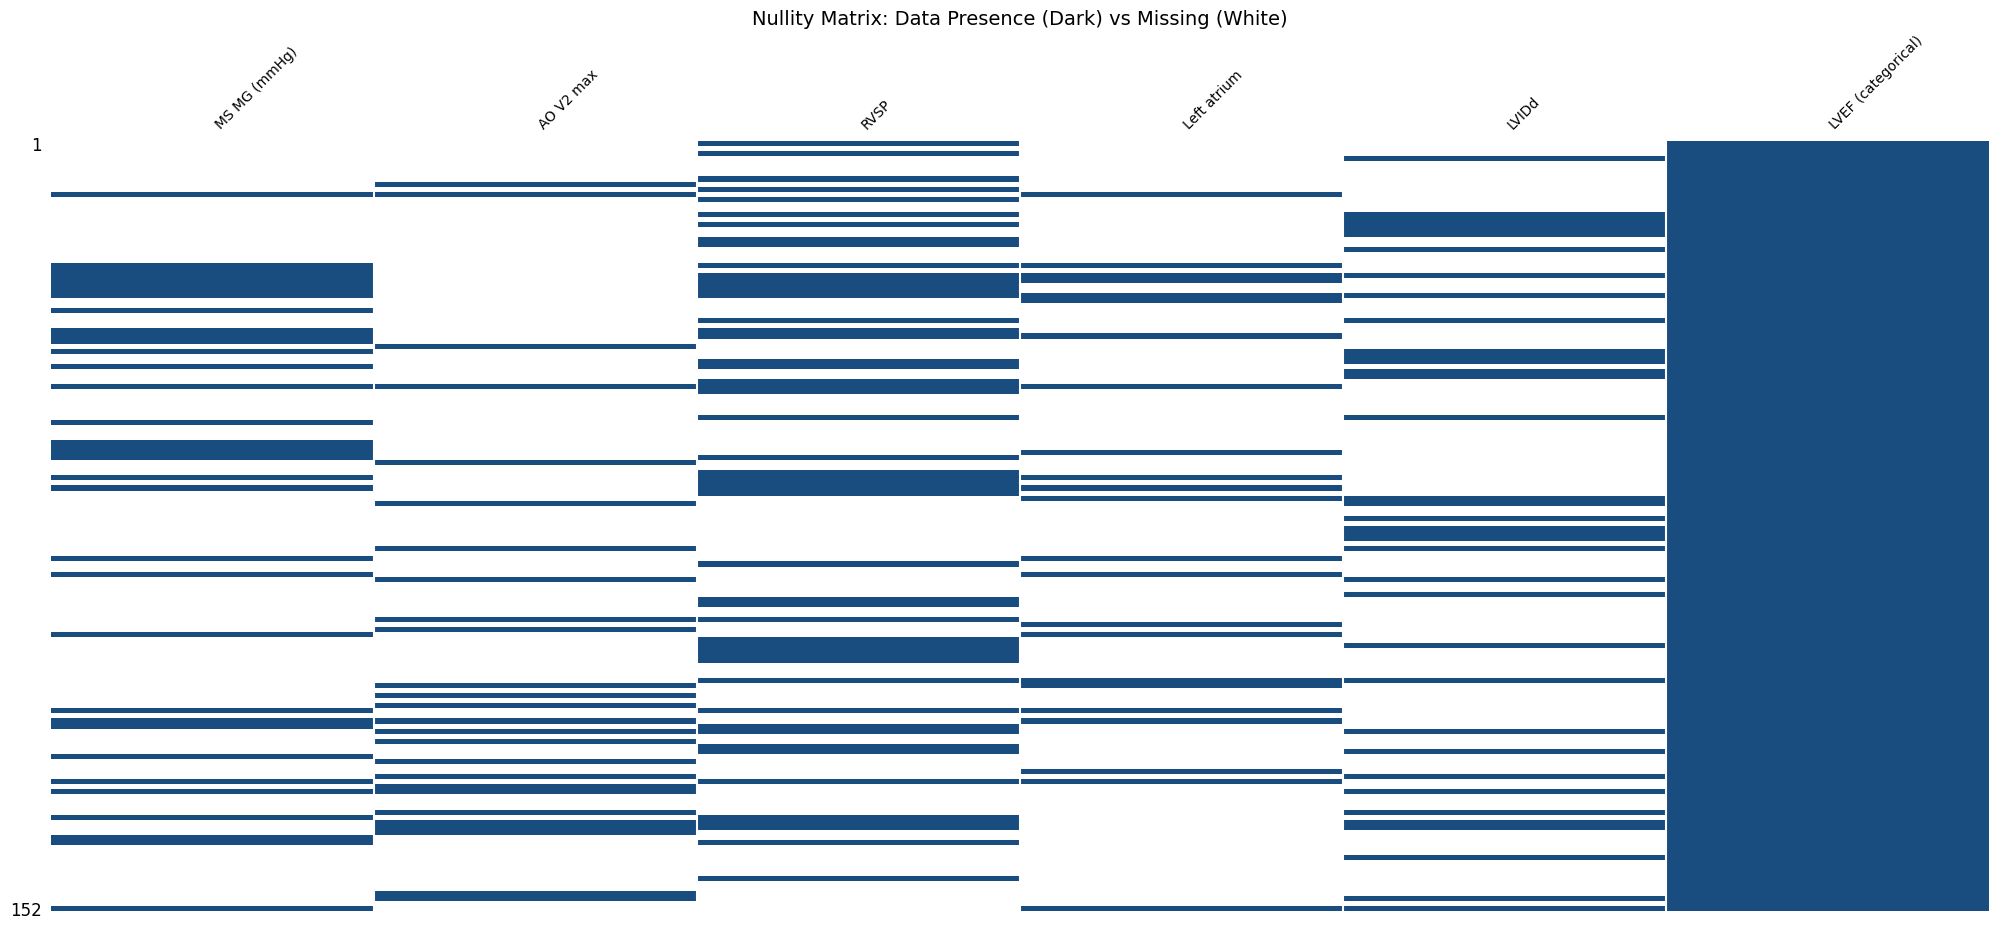

Note: Correlation of Missingness (1.0 = Always missing together):


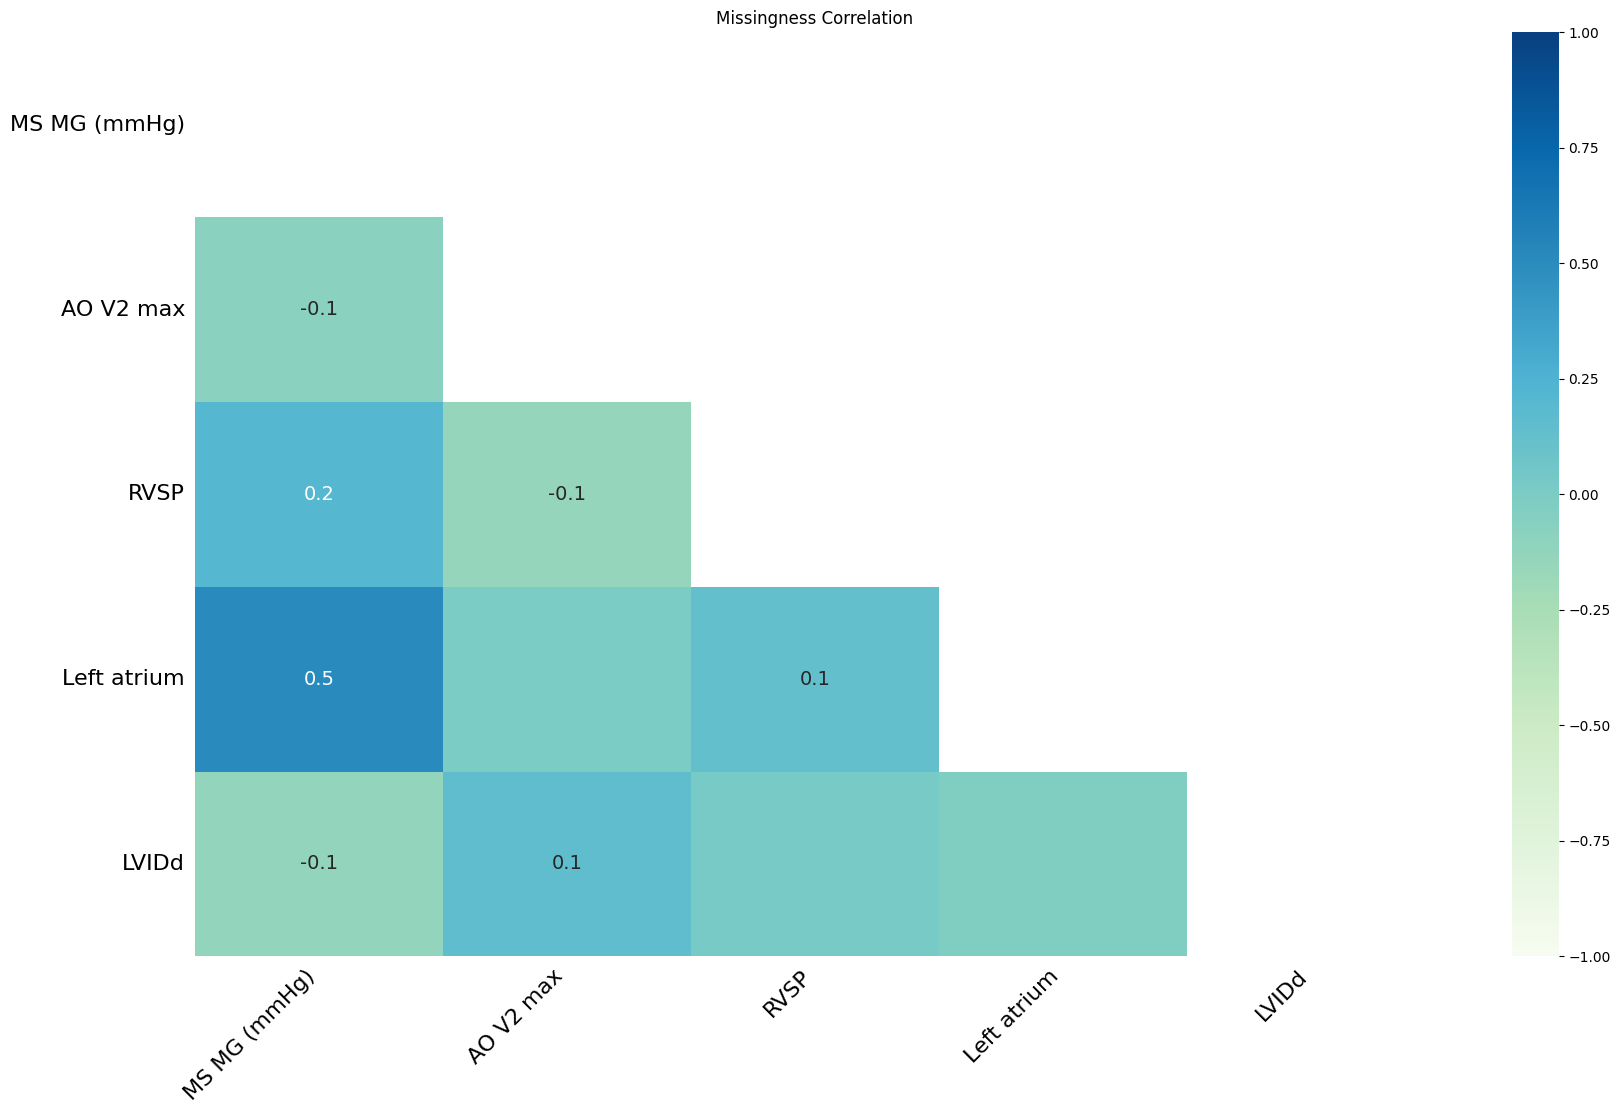

In [8]:
# Prints missingness visuals
# We run echo_missingness first to feed its data to the patient_nullity method
missingness_matrix = auditor.echo_missingness() 

viz.patient_nullity()

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Visual audit: Proving the "Clinical Silence"</strong> 
    <p>We used a two-pronged visual audit to map the "footprint" of the team's workflow
    </p>
    <p><strong>The nullity matrix:</strong> This shows a high-level view of data presence (blue) versus absence (white).</p>
    <ul>
        <li><strong>The striation pattern:</strong> The horizontal white gaps across other hemodynamic variables are not random. They represent patients where the clinician performed a visual assessment, determined the valves were "grossly normal," and intentionally skipped time-consuming quantitative measurements. This suggests data density follows a <strong>pathology-first</strong> logic.</li>
    </ul>
    <p><strong>The correlation heatmap:</strong> This quantifies how the absence of one measurement predicts the absence of another.</p>
    <ul>
        <li><strong>The Mitral-Atrial Cluster (r=0.5):</strong> The strongest correlation in the dataset. Mitral Stenosis (MS) physically causes Left Atrial enlargement. This $0.5$ correlation proves that clinicians work in "anatomical sets." If they identify a Mitral issue, they measure the associated chamber (LA). If the valve is healthy, they skip both.</li>
        <li><strong>RVSP as a triage variable (r=0.2):</strong> Pulmonary pressure (RVSP) shows low correlation with other missingness, confirming it is often attempted as a "standalone" marker of severity, regardless of which valve is being measured.</li>
    </ul>
</div>


Echocardiogram Triage Matrix notes:
----------------------------------------
A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.


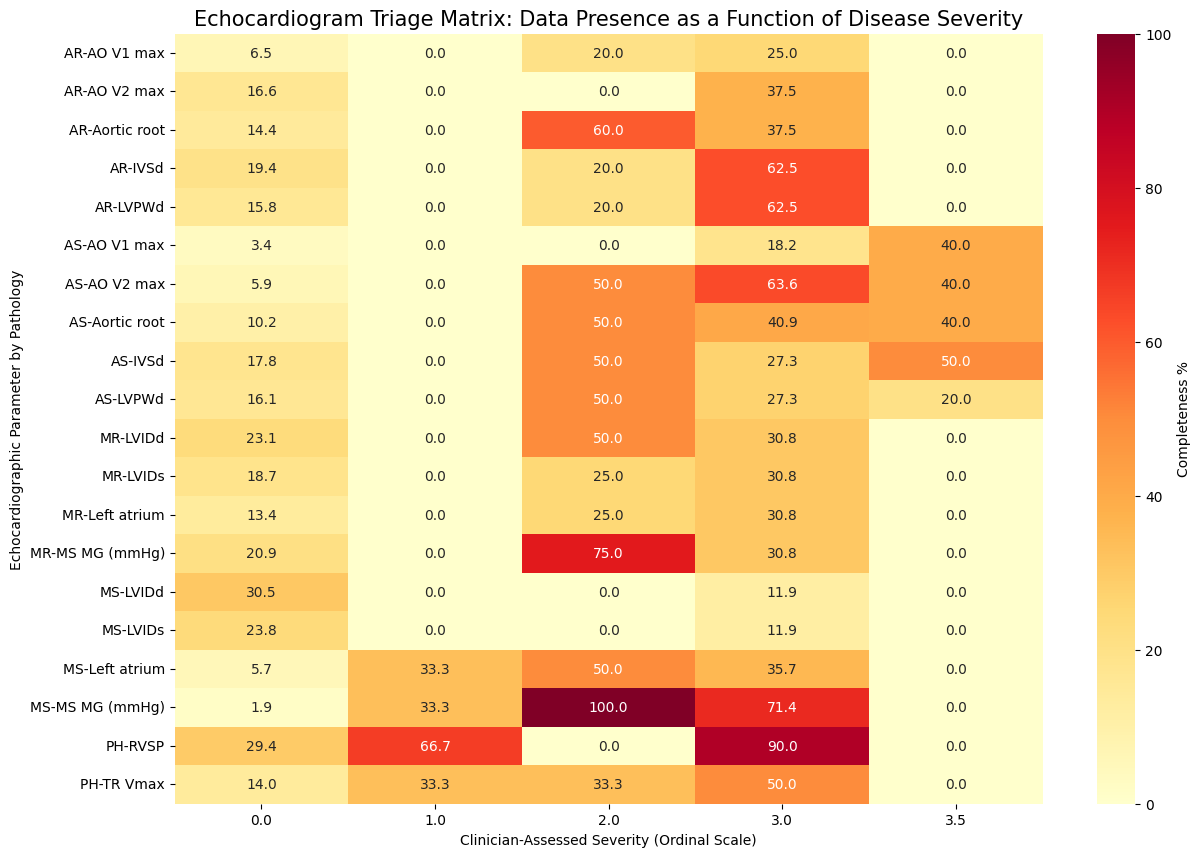

In [9]:
viz.echo_matrix(missingness_matrix)

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">The Echocardiogram Triage Matrix: Data as a Function of Severity</strong> 
    <p>This heatmap illustrates the logic's core of the Brigade team. We plotted the Completeness % of specific echocardiographic parameters against the Clinician-Assessed Severity of the disease.</p>
    <p><strong>The "Severity-Driven Completeness" Trend:</strong> Notice the deep red cells (high completeness) as we move toward the right side of the x-axis (Severity 2.0 to 3.5).</p>
    <ul>
        <li><strong>The finding:</strong> For Mitral Stenosis (MS), when severity is "Critical" (3.0), the completeness of the Mean Gradient (MG) jumps to 71.4%, and it hits 100% for Moderate cases.</li>
        <li><strong>The clinical reasoning:</strong> Clinicians do not measure what is healthy. They only perform time-consuming quantitative assessments when the initial visual "Quick Scan" suggests pathology. This is the definition of Missing Not At Random (MNAR).</li>
    </ul>
    <p><strong>The Pulmonary Hypertension signal:</strong> Look at the PH-RVSP row. At Severity 3.0, the data is 90.0% complete.</p>
    <ul>
        <li><strong>The finding:</strong> RVSP is almost always documented when the patient is severely ill, but only 29.4% documented when severity is 0.0 (None). This confirms that RVSP is a "high-stakes" variable used specifically to validate surgical candidates.</li>
    </ul>
    <p><strong>The "Normal Silence" (Severity 0.0):</strong> The left-most column (Severity 0.0) is almost entirely pale yellow, with completeness often below 10%.</p>
    <ul>
        <li><strong>The finding:</strong> This pattern provides the ultimate justification for our Natural Normal Imputation. It proves that these nulls are not "missing values"—they are confirmed normal findings that the clinicians simply did not have the time to document.</li>
        <li><strong>Conclusion:</strong></li>
    </ul>
    <p>Standard medical statistics and research approaches suggest dropping missing values or using simple averages. However, this matrix proves that doing so would delete 90% of our "Healthy" cohort and bias the model toward the sickest patients. By quantifying the link between Pathology and Documentation, we turn a "data quality issue" into a feature of the clinical workflow.</p>
</div>

**Strategic Feature Selection: Anchoring the Model**

Following our audit, we curated a subset of "High-Impact" variables. Rather than using all available data, we selected these anchors based on their clinical signal and their ability to withstand our "Natural Normal" imputation:

| Variable | Role in Analysis | Reason for selection |
| :- | :- | :- |
| **MS MG** | Primary Functional (Mitral) | Strongest MNAR signal ($1.9\% \rightarrow 100\%$ capture). Essential for quantifying Mitral Stenosis burden. |
| **AO V2 max** | Primary Functional (Aortic) | Key hemodynamic marker for Aortic Stenosis severity and primary surgical decision-making. |
| **RVSP** | Hemodynamic Anchor | Important for secondary disease burden (Pulmonary Hypertension). High capture ($90\%$) in severe cases. |
| **Left atrium** | Primary Remodeling | Despite lower overall capture, LA size serves as the "long-term memory" of mitral disease and volume overload. |
| **LVIDd** | Geometric Anchor | Necessary for identifying the "Remodeling Paradox," specifically for chronic Regurgitation (MR/AR) cases. |

In [10]:
# PHASE 2: Clinical Baseline & Prevalence
# ==========================================
print(f"PHASE 2: Clinical baseline & prevalence\n{'='*40}")
extractor.baseline()
extractor.disease_profiler()

print(f"\nDisease prevalence: (n={len(df)})\n" + '-'*40)
prevalence = extractor.diagnoses_prevalence()
display(prevalence.head(10))

print("\nDisease complexity\n" + '-'*40)
for key, value in extractor.complexity_stats.items():
    print(f"{key}:  {value}")

PHASE 2: Clinical baseline & prevalence
Baseline characteristics
----------------------------------------


,Value,Completeness,Type
Characteristic,,,
Age,47.1 ± 15.7,100.0%,Continuous
Gender,Mode: Female (64.5%),100.0%,Categorical
Weight,71.6 ± 16.2,98.0%,Continuous
OSat,94.9 ± 9.6,99.3%,Continuous
SBP R,124.6 ± 18.7,100.0%,Continuous
DBP R,76.7 ± 12.5,100.0%,Continuous
Heart rate,76.6 ± 14.1,100.0%,Continuous



Disease prevalence: (n=152)
----------------------------------------


,Patient Count,Prevalence (%)
Diagnosis,,
Mitral stenosis,49,32.2
Aortic stenosis,34,22.4
Secundum atrial septal defect,22,14.5
Mitral regurgitation,19,12.5
Pulmonary hypertension,15,9.9
Aortic regurgitation,15,9.9
Surgical aortic valve replacement,14,9.2
Bicuspid aortic valve,12,7.9
Mitral valve percutaneous valvuloplasty,11,7.2



Disease complexity
----------------------------------------
Total Patients:  152
Mixed Mitral:  7
Mixed Aortic:  1
Multi-Valvular:  8
Significant PH (>=2.0):  13
AFib Present:  7



Complexity frequency and stratification
----------------------------------------


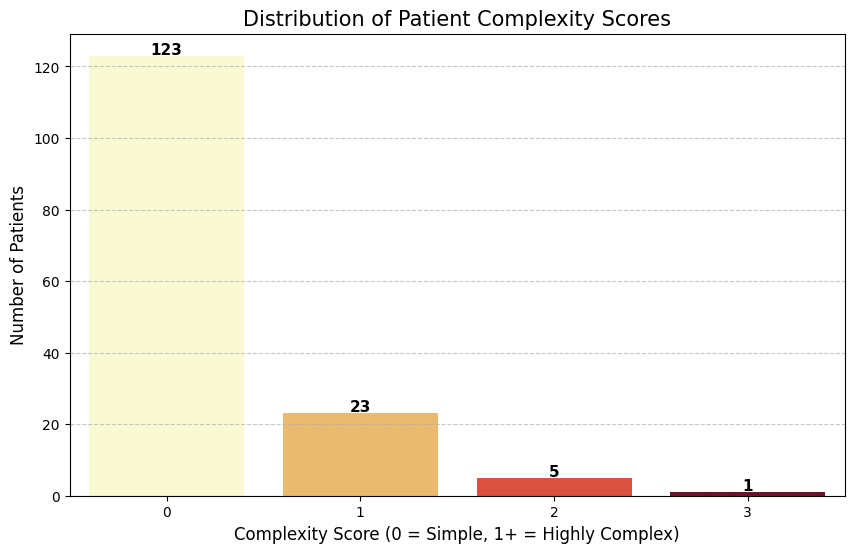

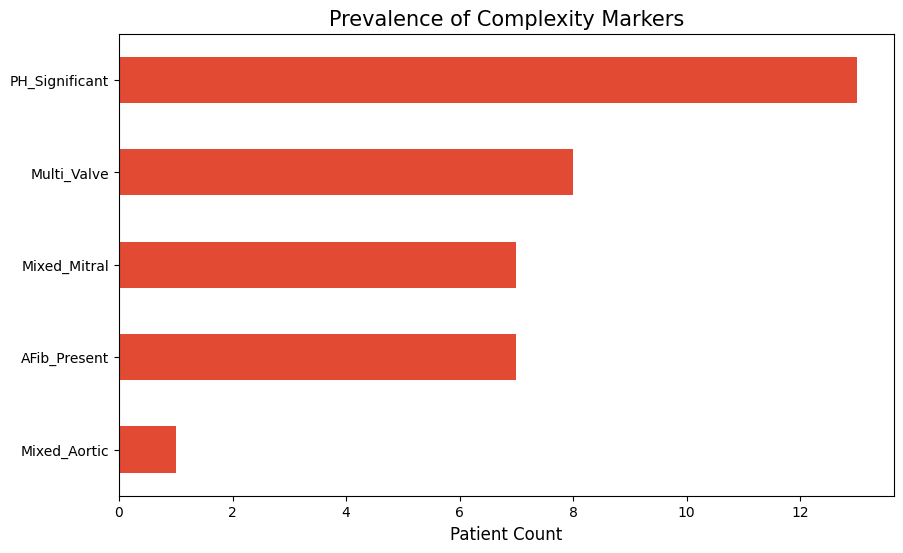

In [11]:
# Complexity Analysis
viz = Visualizer(df, config)
stats.df = df

print("\nComplexity frequency and stratification\n" + '-'*40)
viz.complexity_frequency()
viz.complexity_markers()

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Clinical Cohort Profile</strong> 
    <p><strong>Disease Prevalence: </strong>The Structural Burden</p>
    <ul>
        <li><strong>Rheumatic/Structural Dominance:</strong> Mitral Stenosis (32.2%) and Aortic Stenosis (22.4%) are the primary drivers of the cohort.</li>
        <li><strong>Surgical history:</strong> Nearly 10% of the patients (9.2%) presented with a pre-existing surgical aortic valve replacement, indicating that the brigade is managing a mix of new cases and complex long-term follow-ups.</li>
    </ul>
    <p><strong>Disease complexity: </strong>The high stakes</p>
    <ul>
        <li><strong>Multi-Valvular Involvement:</strong> We identified 8 patients with multi-valvular disease and 7 with Mixed Mitral pathology (Stenosis + Regurgitation).</li>
        <li><strong>Pulmonary Hypertension (PH):</strong> 13 patients presented with Significant PH (moderate or worse), a critical indicator of late-stage disease and surgical risk.</li>
    </ul>
</div>

Echo parameters heatmap interaction
----------------------------------------


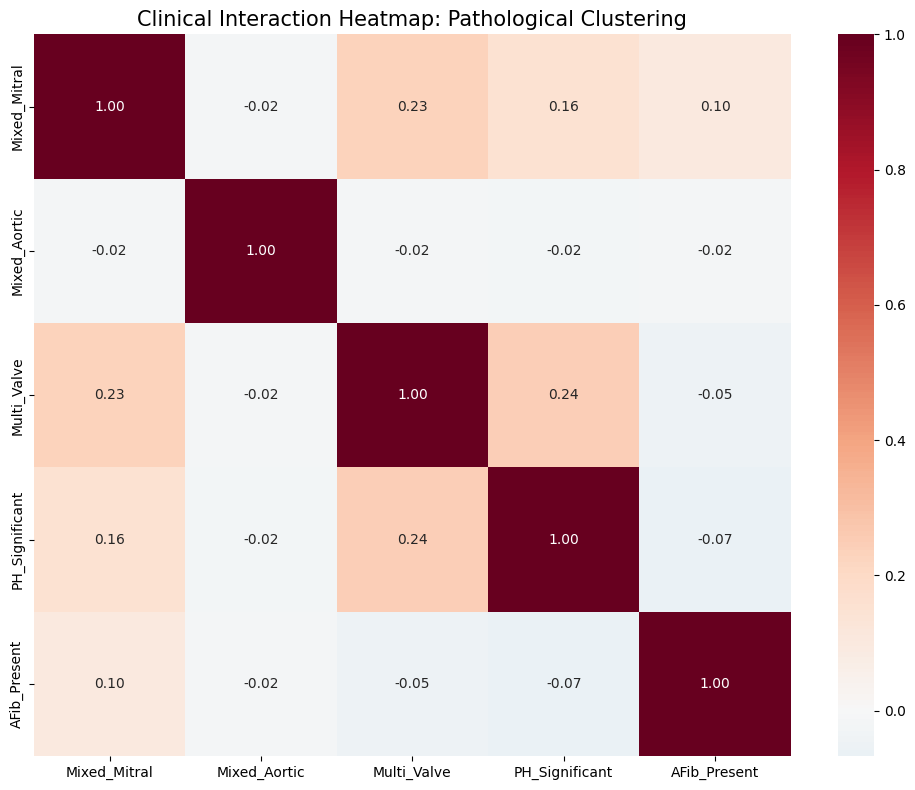

In [12]:
print("Echo parameters heatmap interaction\n" + '-'*40)
viz.complexity_heatmap()

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Clinical interaction heatmap</strong> 
    <p>This heatmap visualizes the interaction between our engineered "Clinical Flags." Rather than looking at raw measurements, we are looking at the coexistence of high-complexity disease states.</p>
    <p><strong>The "Congestive Complex" (Multi-valvular disease and pulmonar hypertension): </strong>We observe a positive interaction (0.24) between multi-valvular disease involvement and significant pulmonary hypertension (defined as moderate or worse).</p>
    <ul>
        <li><strong>Clinical insight:</strong> This statistical link points out the physiological progression of valvular disease. Patients with multiple diseased valves often develop secondary Pulmonary Hypertension due to chronic volume and pressure overload.</li>
    </ul>
    <p><strong>Mitral complexity and secondary effects: </strong>There is a positive interaction (0.23) between mixed Mitral valve disease (stenosis + regurgitation) and Multi-valvular disease.</p>
    <ul>
        <li><strong>Clinical insight:</strong> Patients with complex mitral presentations are statistically more likely to have concomitant Aortic or Tricuspid pathology.</li>
    </ul>
    <p><strong>The "independece" of Aortic cases: </strong>Mixed aortic valve disease shows almost zero or slightly negative correlations with other pathologies (around -0.02).</p>
    <ul>
        <li><strong>Clinical insight:</strong> In the 2025 cohort, complex Aortic presentations appear to be more "isolated" than Mitral cases. This suggests a different patient phenotype—potentially older patients with degenerative calcific disease</li>
    </ul>
    <p>This interaction analysis proves that our feature engineering isn't just creating labels; it's capturing <strong>clinical phenotypes.</strong></p>
</div>

**The Medication Burden Index (MBI)**

The centerpiece of our feature engineering is the Medication Burden Index. This score quantifies how aggressively a patient is being medically managed, which serves as a proxy for both physiological severity and care complexity.

We define the score mathematically as:

$$MBI = \sum_{i=1}^{n} \left( \text{Weight}_{\text{class}_i} \times \frac{\text{TDD}_i}{\text{Dose}_{\text{max}_i}} \right)$$

* **Weight:** Assigned in `ClinicalConfig` based on the drug's therapeutic impact (e.g., Loop Diuretics have a higher weight than Lipid Lowering agents).

* **Dose Ratio:** The actual dose relative to the maximum per clinical guidelines. **The dose ratio normalizes intra-group medication intensity**, ensuring that the "burden" is calculated based on pharmacological effort rather than raw milligram weight.

**Case study: Normalizing calcium channel blockers (CCBs)**

To understand why the Total Daily Dose (TDD) and Dose Ratio are necessary, consider two patients on different CCBs from our cohort:

| Patient | Medication | Raw dosage | Frequency | Total Daily Dose (TDD) | Max Daily dose | Dose ratio |
| :- | :- | -: | :- | -: | -: | -: |
| A | **Nifedipine** | 20 mg | BID | 40 mg | 120 mg | 0.33 |
| B | **Amlodipine** | 10 mg | QD | 10 mg | 10 mg | 1.00 |

* **Total Daily Dose (TDD):** Raw milligrams are inherently misleading. The Regex Engine must identify the numeric dosage ($20$) and the frequency multiplier ($BID = \times 2$) to find the true daily intake ($40\text{ mg}$).

* **Normalization:** Without the Dose Ratio, Patient A would appear to have four times the "burden" of Patient B ($40\text{ mg}$ vs $10\text{ mg}$). However, because $10\text{ mg}$ is the therapeutic ceiling for Amlodipine, Patient B is actually at **100% therapeutic intensity**, while Patient A is only at 33%.

* **Result:** The MBI correctly identifies Patient B as having a higher pharmacological burden, reflecting a more aggressive clinical management strategy for their condition.

In [13]:
# PHASE 3: Statistical Imputation & MBI
# ==========================================
print(f"\nPHASE 3: Statistical Imputation & MBI\n{'='*40}")
stats.apply_imputation()
calculator_execute = calc.medication_index().head(5)

case_ids = ["66", "120", "55"]
mbi_rows = df.loc[df.index.isin(case_ids), ['Anatomy_Pre', 'Medications', 'MBI']]
print("\nMBI rows showcase\n" + '-'*40)
display(mbi_rows)


PHASE 3: Statistical Imputation & MBI
Handled MS MG (mmHg) using 'Natural Normal' distribution.
Handled AO V2 max using 'Natural Normal' distribution.
Handled RVSP using 'Natural Normal' distribution.
Handled LVIDd using 'Natural Normal' distribution.

MBI rows showcase
----------------------------------------


,Anatomy_Pre,Medications,MBI
ID,,,
120,"Pulmonary hypertension, Mitral stenosis",Warfarin 2.5 mg QD | Furosemide 40 mg BID | Ca...,4.75
66,"Aortic stenosis, Mitral stenosis",Warfarin 5 mg QD | Enalapril 10 mg BID,2.00
55,"Atrial fibrillation, Mitral stenosis, Mitral r...",Amlodipine 10 mg QD | Bisoprolol 5 mg QD | Spi...,6.25


### 5. Pipeline Step 3: Statistical Modeling (The Proof)
---

**Goal:** To validate the MBI as a robust proxy for anatomical complexity and ensure the integrity of our "Natural Normal" imputation.

**1. Imputation Sensitivity Analysis**

Before performing high-level analytics, we must ensure our "Natural Normal" strategy didn't dilute the clinical signal. We execute sensitivity_grid() to visualize the distribution of the data before and after the injection of Gaussian noise.

* **The Comparison:** We plot **Measured** (Red) vs. **Cohort** (Green) distributions.

* **The Validation:** If the Green distribution fills the "Normal" range without shifting the "Red" pathological peaks, the imputation is successful. This confirms we have created a realistic clinical baseline for the 2025 cohort.

PHASE 4: Visualizing imputation of Data and MBI validity
Sensitivity analysis for the Stochastic Imputation
----------------------------------------


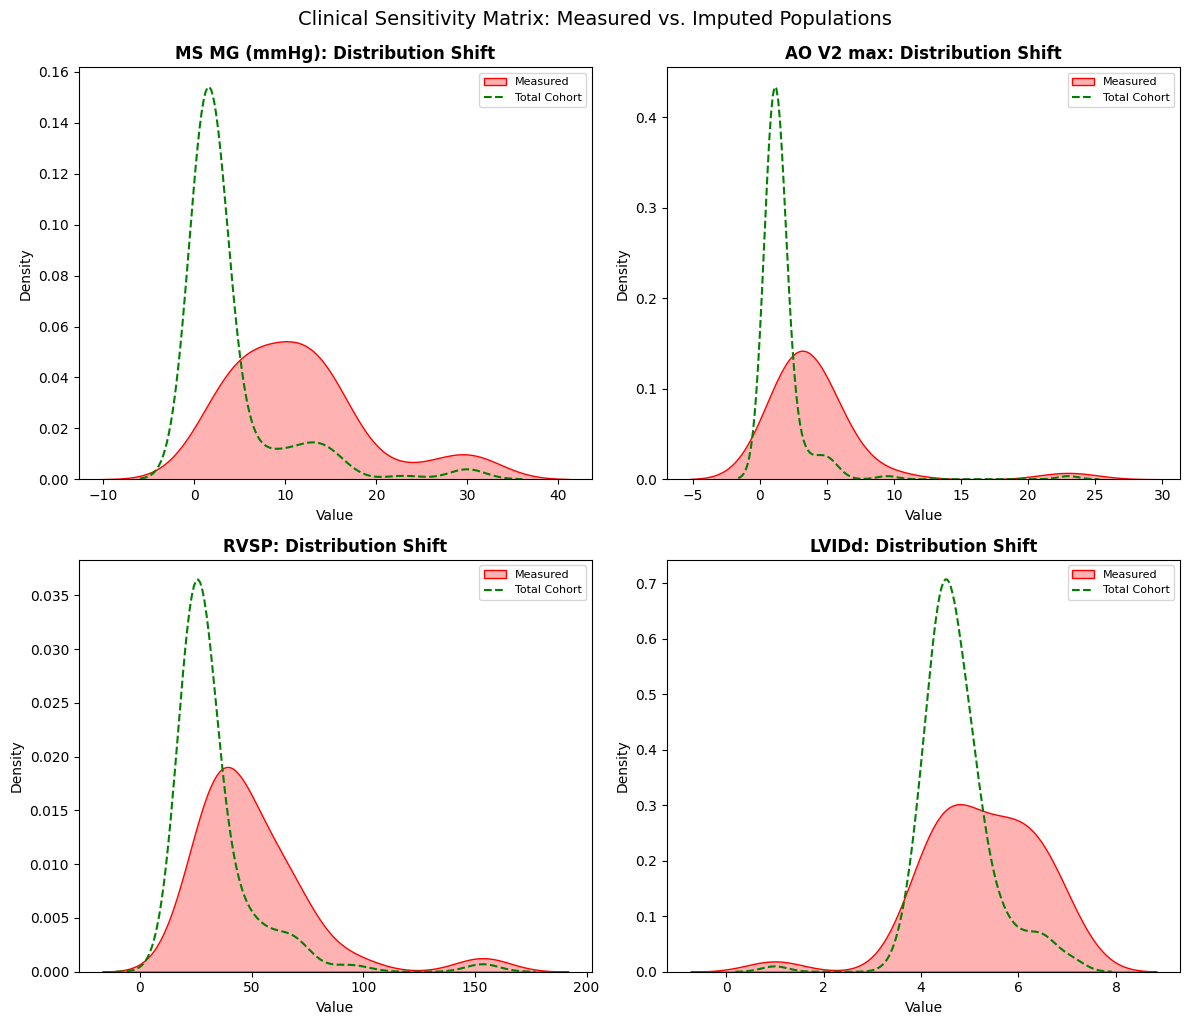

,Measured Mean,Cohort Mean,Delta (Shift),Triage Bias,Sample Size (n)
Clinical Parameter,,,,,
MS MG (mmHg),11.4,3.8,-7.6,Significant Shift,35
AO V2 max,4.3,1.6,-2.6,Significant Shift,26
RVSP,51.0,33.6,-17.5,Significant Shift,51
LVIDd,5.2,4.7,-0.5,Stable,37


In [14]:
# PHASE 4: Visualizing imputation of Data and MBI validity
# ==========================================
print(f"PHASE 4: Visualizing imputation of Data and MBI validity\n{'='*40}")

# Sensitivity analysis
print("Sensitivity analysis for the Stochastic Imputation\n" + '-'*40)
viz.sensitivity_grid()
sensitivity_table = stats.sensitivity_report()
display(sensitivity_table)

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Sensitivity analysis and signal preservation</strong> 
    <p>The output above confirms that our <strong>Natural Normal Imputation</strong> successfully restored the clinical baseline for the 2025 cohort. By comparing the Measured distribution (patients with documented disease) against the Total Cohort (Measured + Imputed), we can draw three critical conclusions:</p>
    <ul>
        <li><strong>Pathological signal integrity:</strong> In the density plots the "Red" pathological peaks remain distinct and unshifted. This proves that our imputation did not "wash out" the sickest patients; we simply filled the "Clinical Silence" around them.</li>
        <li><strong>Quantifying the Triage Bias:</strong>  The table reveals a Significant Shift in means for hemodynamic variables, such as RVSP dropping from 51.0 mmHg (measured) to 33.8 mmHg (cohort). This delta is the mathematical proof of a <strong>High-Severity Documentation Threshold</strong>. It confirms that clinicians only performed time-intensive quantitative measurements when a preliminary "Quick Scan" indicated significant pathology—leaving the healthy portion of the population "silent" but present.</li>
        <li><strong>Statistical stability (LVIDd):</strong> Unlike the hemodynamic variables, LVIDd remained remarkably stable (Delta of only -0.5). This suggests that basic structural dimensions are more consistently captured across all severity levels compared to complex flow gradients.</li>
    </ul>
</div>

**2. ROC Analysis: Finding the Triage "Cutoff"**

To provide actionable value for the brigade, we determine the predictive power of the MBI in identifying "High Complexity" surgical candidates.

* **The Metric:** We generate a Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).

* **The Optimal Cutoff:** We identify the MBI score at a cutoff of $4.0$ provides the best balance of sensitivity (catching all sick patients) and specificity (not over-flagging healthy ones).

ROC visualization for MBI
----------------------------------------


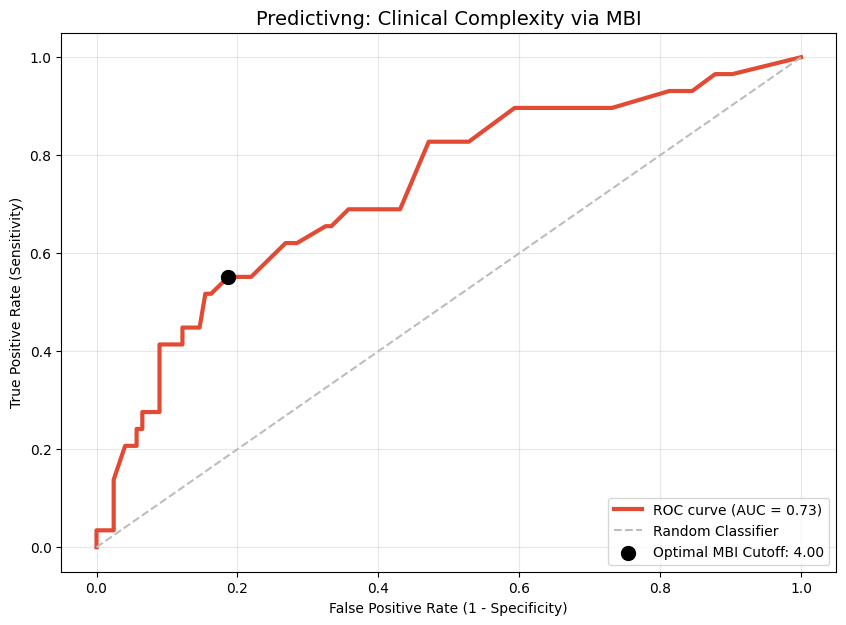

Analysis Complete: A value of MBI above 4.00 is the best predictor of patient complexity.

MBI Threshold Validation (> 4.0)
----------------------------------------
F1-Score:  0.421
Precision: 0.800 (Reliability: When MBI is high, is the patient actually sick?)
Recall:    0.286 (Sensitivity: Does MBI catch all the sick patients?)

Confusion matrix visualization
----------------------------------------


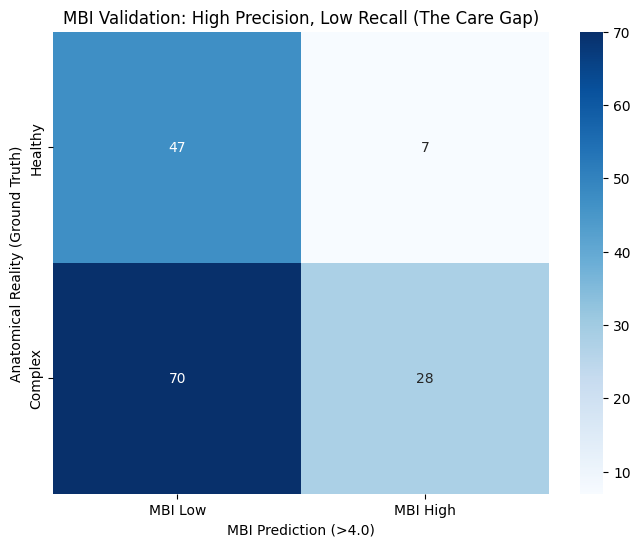

In [15]:
# ROC analysis
stats.roc(predictor_col='MBI')

# Validation of the MBI threshold
# 2.0 for a moderate cutoff
anatomical_threshold = 2.0 
df['Is_Complex_Anatomic'] = (df[config.lesions_anatomic].max(axis=1) >= anatomical_threshold).astype(int)

# Apply the MBI Cutoff (The Predictor)
mbi_cutoff = 4.0
df['MBI_Predicted_High'] = (df['MBI'] > mbi_cutoff).astype(int)
matrix = stats.validate_predictor(mbi_cutoff)
viz.validate_vis(matrix, 
                 'MBI Prediction (>4.0)', 'Anatomical Reality (Ground Truth)', 
                 'MBI Validation: High Precision, Low Recall (The Care Gap)'
)

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Model Validation: Quantifying the MBI as a Triage Filter</strong> 
    <p>The combination of the ROC Curve and the Confusion Matrix reveals how the Medication Burden Index (MBI) serves as a "High-Specificity" filter for clinical triage.</p>
    <p><strong>Predictive Power (ROC Analysis):</strong> The ROC curve shows an <strong>AUC of 0.73.</strong> In a field setting with messy, free-text data, an AUC above 0.70 is a significant clinical victory. It proves that a patient's medication list alone carries a strong enough signal to distinguish anatomical complexity from health, far better than a random guess.</p>
    <p><strong>High Precision (Reliability Factor):</strong> The confusion matrix yields a Precision of 0.80, meaning that when the MBI flags a patient as "High Risk" (> 4.0), the model is correct <strong>80% of the time.</strong> In a high-volume clinical setting, this high Positive Predictive Value (PPV) ensures that an "MBI High" alert serves as a reliable trigger, almost certainly warranting a thorough review and confirmatory transesophageal ecocardiographic evaluation.</p>
    <p><strong>Low Recall (The Care Gap):</strong> The model shows a lower Recall of 0.286 (identifying 28 out of 98 complex cases). While this might look like a technical weakness, it actually reveals a profound clinical insight:
        <ul>
            <li><strong>The "Untreated" Population:</strong> These 70 patients (False Negatives) have complex anatomical disease but a Low MBI. This suggests they are "under-managed"—sick patients who are not yet on the aggressive medication regimens their condition requires.</li>
            <li><strong>The Opportunity:</strong> The MBI doesn't just find sick patients; it identifies the <strong>Care Gap</strong>. These are the patients who have the disease but haven't been optimized medically.</li>
        </ul>
    </p>
</div>

In [16]:
mbi_decomposed = viz.predictor_decomposition()

# TODO Comment on the decomposed MBI

Global MBI burden, stratified by medication classes
----------------------------------------


Bars represent **aggregate population burden**    
Color indicate **clinical priority** weights


KEY MBI FINDINGS SUMMARY: PHARMACOLOGICAL DRIVERS
Total Cohort Burden Score: 434.9

TOP 3 CLINICAL DRIVERS:
1. Anticoagulants_Antiplatelets | Burden:  90.5 (20.8%)
   - Dominant Medication: Aspirin (47.5% of class)
2. RAAS_Inhibitors           | Burden:  69.2 (15.9%)
   - Dominant Medication: Losartan (55.3% of class)
3. Beta_Blockers             | Burden:  68.3 (15.7%)
   - Dominant Medication: Carvedilol (49.1% of class)



<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Global MBI architecture and clinical drivers</strong> 
    <p>This visualization breaks down the aggregate MBI score into its constituent medication classes. This allows us to move beyond a single number and see the <strong>pharmacological fingerprint</strong> of the 2025 cohort.</p>
    <p><strong>The dominance of "bridging" medications</strong></p>
    <p>The highest weighted contributions come from <strong>Anticoagulants/Antiplatelets</strong> and <strong>RAAS Inhibitors/Beta-Blockers.</strong></p>
    <ul>
        <li><strong>Clinical insight: </strong>This reflects a cohort heavily populated by patients with mechanical valve history, atrial fibrillation, and advanced heart failure. These drugs are the "standard of care" for stabilizing patients while they await surgical intervention.</li>
        <li><strong>MBI signal: </strong>Because these classes are common, they provide the "baseline" burden for the majority of the intervention candidates.</li>
    </ul>
    <p><strong>High-intensity markers: Diuretics and Pulmonary Vasodilators</strong></p>
    <p>Notice the deep red color in <strong>Diuretics (Loop)</strong> and <strong>Pulmonary Vasodilators.</strong></p>
    <ul>
        <li><strong>Medical weight tier: </strong>These classes are assigned the highest weights (Tier 3.0) because their presence almost always signifies symptomatic congestive heart failure or pulmonary hypertension.</li>
        <li><strong>Clinical insight: </strong>Although these classes contribute less to the total cumulative volume than RAAS inhibitors, they are the primary drivers for "High-Risk" MBI spikes (>4.0). A patient taking a high-dose loop diuretic is physiologically "louder" in the model's eyes than a patient on simple lipid-lowering agents.</li>
    </ul>
    <p><strong>The "metabolic base"</strong></p>
    <p>Classes like <strong>Lipid lowering</strong> and <strong>Metabolic/endocrine</strong> medications show very low contribution and blue "weight Tiers"</p>
    <ul>
        <li><strong>Clinical insight: </strong>his proves that the MBI is correctly deprioritizing general primary care medications. It ensures that a patient with high cholesterol but a healthy heart doesn't accidentally get flagged as a high-complexity surgical candidate.</li>
    </ul>
</div>

**3. Regression Analysis: What Drives the Medication Burden?**

We run `run_regression()` to determine if our engineered Medication Burden Index (MBI) truly reflects the anatomical severity recorded during Phase 1.

**The Model:**

$$MBI = \beta_0 + \beta_1(RVSP) + \beta_2(MS~MG) + \beta_3(AO~V2~max) + \epsilon$$

* **Key Findings:** We look for statistically significant coefficients ($\rho < 0.05$) for markers like RVSP (Right Ventricular Systolic Pressure).

* **Interpretation:** A strong positive correlation proves that as a patient's heart physically struggles (higher pressures, larger chambers), their pharmacological "burden" increases proportionally.


CROSS-STRATA COMPARISON: MBI


,Native Coef,Percutaneous Coef,Surgical Coef
const,2.270 **,1.833,0.436
Sev_MS,0.188,0.741,0.730 *
Sev_MR,0.569 *,-0.167,0.521
Sev_AS,0.082,0.000,0.501 *
Sev_AR,0.121,0.000,0.563
Mixed_Mitral,1.353,-0.056,0.000
Mixed_Aortic,-2.295,0.000,0.000
Multi_Valve,-0.364,0.000,-1.003
Sev_PH,0.604 **,0.000,0.000
AFib_Present,1.881 *,0.000,-0.125


Notes:   ** - p < 0.01 | * - p<0.05

Residuals visualization to compare prediciton errors across intervention groups
----------------------------------------


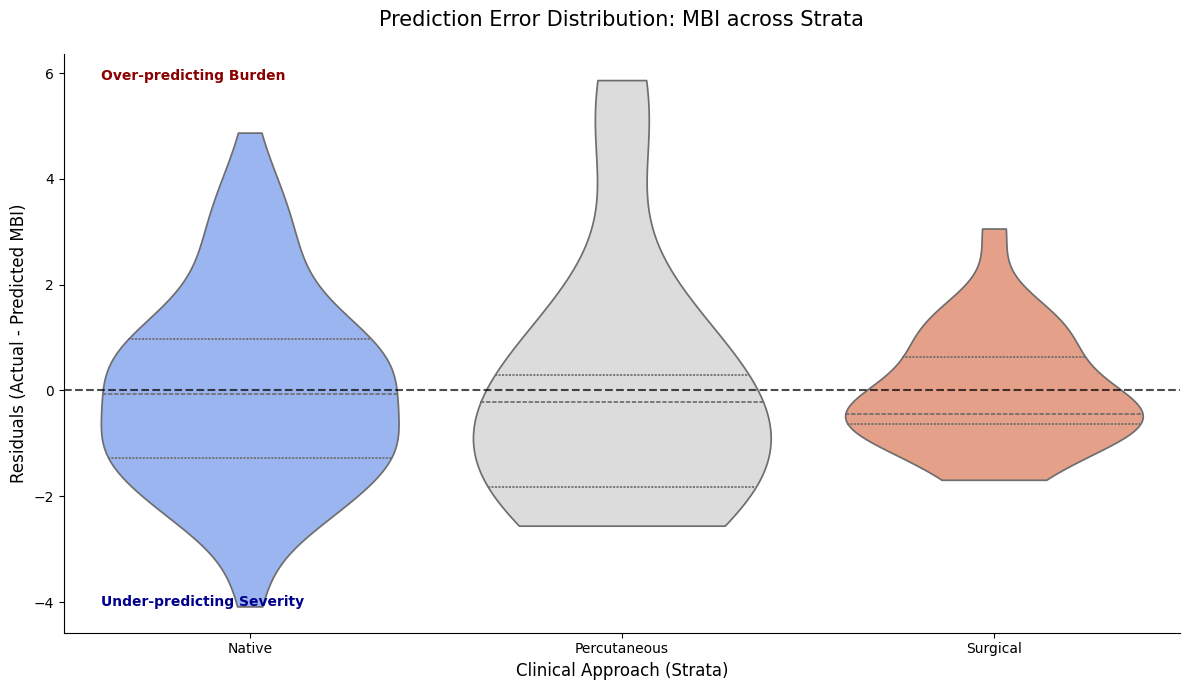

In [17]:
# PHASE 5: Regression for mismatches
# ==========================================
# * Variables to be used for regression
"""
These lists are left empty because we want to run a first, exploratory regression
This will give us an overview into the differences per intervention status
So far, we are going to focus on lesions only, to see how much of this data's MBI
is explained by anatomy of the lesions.
"""
# This are the lists to be passed to the method run_regression
# We are starting with the anatomic variables and then add/modify accordingly
config.regression_echo = []
config.regression_demographics = []
config.regression_lesions = ['Sev_MS','Sev_MR', 'Sev_AS', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'Sev_PH', 'AFib_Present']

# Runs regression across all intervention groups
mbi_mismatch = stats.run_regression(y_var='MBI')

# ! To use residual_distribution method, make sure no strata is selected
print("Residuals visualization to compare prediciton errors across intervention groups\n" + '-'*40)
viz.residual_distribution(mbi_mismatch, y_var='MBI')

In [18]:
# Runs regressions using MBI as a dependent variable, only on the Native cohort
# We comment out the demographics variables but state them here son we don't forget its existance
# config.regression_demographics = [] 
# config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_lesions = ['Sev_MS','Sev_MR', 'Sev_AS', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'Sev_PH', 'AFib_Present']
mbi_mismatch_native = stats.run_regression(y_var='MBI', strata='Native')


DEEP DIVE: MBI NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:                    MBI   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.451
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           6.40e-05
Time:                        21:41:28   Log-Likelihood:                -222.20
No. Observations:                 110   AIC:                             464.4
Df Residuals:                     100   BIC:                             491.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Clinical Synthesis: Determinants of Medication Burden</strong> 
    <p><b>1. Primary Drivers:</b> In the <b>Native</b> cohort, <i>Atrial Fibrillation</i> (coef. 1.88), <i>Pulmonary Hypertension</i> (coef. 0.60), and <i>Mitral Regurgitation</i> (coef. 0.57) are the statistically significant predictors of MBI. This confirms that medication strategies in non-operative patients are primarily "defensive," targeting symptomatic complications like congestion and rhythm instability.</p>
    <p><b>2. The "Mixed Mitral" Signal:</b> Although <i>Mixed Mitral Disease</i> did not reach statistical significance (<i>p > 0.05</i>), its high coefficient of <b>1.35</b> suggests a potent clinical impact. This likely represents an additive or exponential burden where the combination of stenosis and regurgitation warrants a thorough review and confirmatory transesophageal ecocardiographic evaluation than isolated lesions.</p>
    <p><b>3. Stratified Baseline (The Constant):</b> The model reveals a descending baseline burden as we move toward definitive intervention. The <b>Native</b> constant (2.27) reflects high background therapy for "pre-op" stabilization, whereas the <b>Surgical</b> constant is significantly lower (0.43), signaling a reduced reliance on chronic heart failure medications following anatomical correction.</p>
    <p><b>4. Model Performance:</b> The <i>R squared</i> of <b>0.28</b> indicates that while valvular lesions are key drivers, roughly 72% of the variance in medication burden is influenced by other factors. We will now run subsequent regression to see if by adding specific variables we improve the model's performance.</p>
    <p><b>5. Residual Analysis (The Triage Gap):</b> The violin plots reveal the 'clinical outliers' that the model cannot explain. The <b>low-end tail in the Native group</b> likely represents medical undertreatment (anatomically sick patients on minimal medication). Conversely, the <b>high-end "chimneys" in Native and Percutaneous strata</b> highlight the 'Mismatch' group—patients whose high medication burden is disproportionate to their echo findings, suggesting uncaptured frailty or non-valvular complications.</p>
</div>

In [19]:
# Now we add echo parameters and remove any variable that may show collinearity
# We comment out the demographics variables but state them here son we don't forget its existance
# config.regression_demographics = [] 
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
mbi_mismatch_native = stats.run_regression(y_var='MBI', strata='Native')


DEEP DIVE: MBI NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:                    MBI   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4.017
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           4.79e-05
Time:                        21:41:28   Log-Likelihood:                -218.54
No. Observations:                 110   AIC:                             463.1
Df Residuals:                      97   BIC:                             498.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
c

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Deep Dive: Native Cohort Refined Model</strong> 
    <p><b>1. Hemodynamic Dominance:</b> By transitioning from categorical scores to continuous echo data, <i>RVSP</i> emerges as a primary driver of medication burden (<i>p < 0.001</i>). This confirms that in the Native cohort, the MBI functions as a reliable pharmacological proxy for pulmonary congestion and right-heart pressure.</p>
    <p><b>2. Improved Explanatory Power:</b> Even after removing categorical lesion scores to reduce collinearity, the <i>R-squared</i> stands at <b>0.34</b>. This validates that medication burden is heavily influenced by "how the heart is compensating" (pressures and chamber sizes) rather than just the presence of a sick valve.</p>
    <p><b>3. The "Mixed Mitral" Multiplier:</b> The coefficient for <i>Mixed Mitral</i> disease has increased to <b>2.04</b> and reached statistical significance (<i>p < 0.05</i>). This is a major finding: having both stenosis and regurgitation adds over 2 full units to the MBI, making it the single most powerful clinical predictor in the model, identifying a highly complex phenotype that warrants priority TEE (transesophageal echocardiographic) evaluation.</p>
    <p><b>4. Anatomical Remodeling:</b> <i>Left Atrial Size</i> has emerged as a significant trend (<i>p < 0.05</i>) with a coefficient of <b>0.40</b>. This indicates that chronic remodeling—a marker of long-term disease progression—is a primary trigger for escalating pharmacological therapy in this population.</p>
</div>

In [20]:
# Runs regressions using MBI as a dependent variable, only on the Native cohort
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_demographics = ['Age', 'Weight', 'Gender_Male']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
mbi_refined_native = stats.run_regression(y_var='MBI', strata='Native')


DEEP DIVE: MBI NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:                    MBI   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     4.990
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           7.16e-07
Time:                        21:41:28   Log-Likelihood:                -210.41
No. Observations:                 110   AIC:                             450.8
Df Residuals:                      95   BIC:                             491.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
c

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;"> <strong style="font-size: 1.2em;">Final Synthesis: The Integrated Native Model</strong>
<p><b>1. The "Mixed Mitral" Multiplier:</b> The coefficient for <i>Mixed Mitral</i> disease has increased to <b>2.22</b> while retaining statistical significance (<i>p < 0.026</i>), making it the single most powerful clinical predictor in the model.</p>
<p><b>1. The Weight Factor:</b> Patient <i>Weight</i> emerges as a highly significant driver (<b>coef. 0.035, p = 0.011</b>). This indicates that for every 10kg increase in body weight, medication burden increases significantly, likely due to dosing requirements or weight-related comorbid stability issues.</p>
<p><b>2. Hemodynamic Stability:</b> <i>RVSP</i> remains the most consistent and reliable predictor (<b>p < 0.001</b>). The model consistently identifies pulmonary pressure as the primary "trigger" that clinicians respond to when escalating pharmacological therapy.</p>
<p><b>3. Anatomical Remodeling:</b> <i>Left Atrial Size</i> now sits on the cusp of significance (<b>p = 0.059</b>). This suggests that as the atrium enlarges (remodeling), the MBI increases, likely reflecting the introduction of anticoagulants or advanced heart failure therapies.</p>
<p><b>4. Model Maturity:</b> Achieving an <b>R-squared of 0.425</b> with a stable <b>Durbin-Watson (1.95)</b> suggests that the model is well-specified and free of major autocorrelation issues. This integrated approach successfully bridges the gap between raw echo data and clinical practice.</p>
</div>


CROSS-STRATA COMPARISON: RVSP_Imputed


,Native Coef,Percutaneous Coef,Surgical Coef
const,39.631,67.228,-
Age,-0.072,-0.077,-0.052
Weight,-0.245,0.484,0.006
MBI,4.522 **,0.097,0.670
Sev_MR,-0.464,-6.590,1.370
Sev_AR,1.963,0.000,-1.770
Mixed_Mitral,-6.236,-2.197,-0.000
Mixed_Aortic,-6.756,-0.000,0.000 *
Multi_Valve,3.734,-0.000,-0.503
AFib_Present,-5.089,-0.000,-14.840 *


Notes:   ** - p < 0.01 | * - p<0.05

Residuals visualization to compare prediciton errors across intervention groups
----------------------------------------


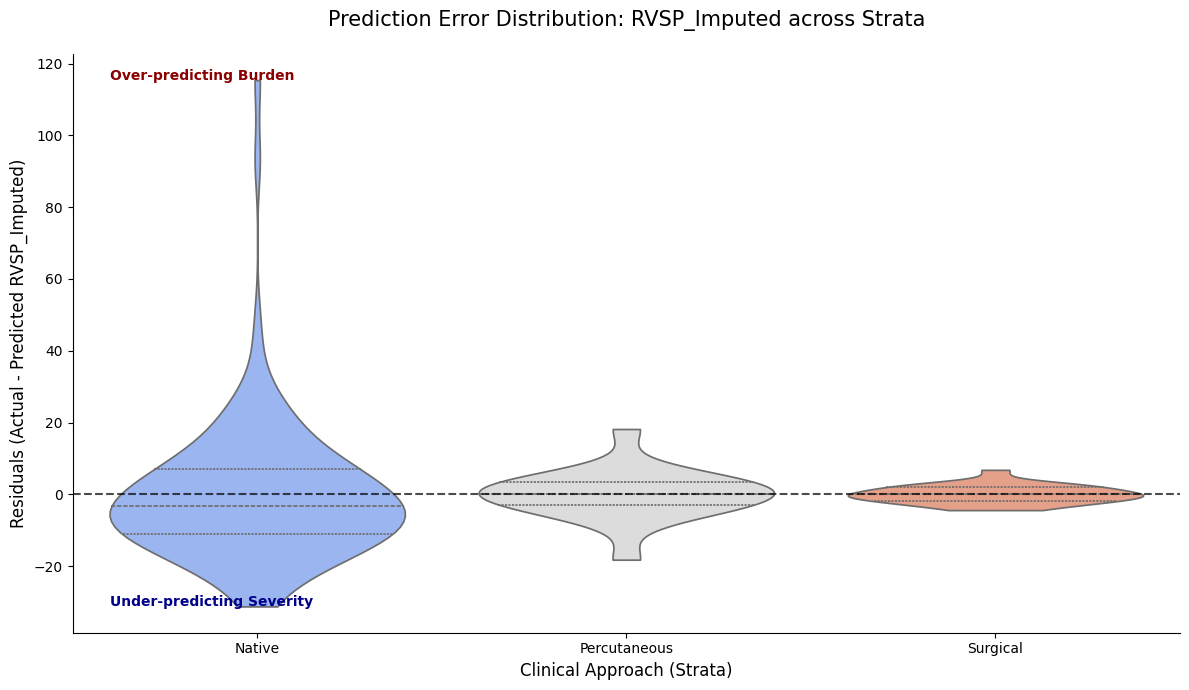

In [21]:
# Runs regressions using RVSP as a dependent variable
# We will add MBI to the demographics group
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_demographics = ['Age', 'Weight', 'Gender_Male', 'MBI']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
rvsp_mismatch = stats.run_regression(y_var='RVSP_Imputed')

print("Residuals visualization to compare prediciton errors across intervention groups\n" + '-'*40)
viz.residual_distribution(rvsp_mismatch, y_var='RVSP_Imputed')

In [22]:
# We will limit the regression's strata to Native only
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_demographics = ['Age', 'Weight', 'Gender_Male', 'MBI']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
rvsp_mismatch_native = stats.run_regression(y_var='RVSP_Imputed', strata='Native')


DEEP DIVE: RVSP_Imputed NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:           RVSP_Imputed   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2.065
Date:                Sat, 03 Jan 2026   Prob (F-statistic):             0.0206
Time:                        21:41:28   Log-Likelihood:                -484.51
No. Observations:                 110   AIC:                             999.0
Df Residuals:                      95   BIC:                             1040.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;">
    <strong style="font-size: 1.2em;">Hemodynamic Analysis: Drivers of Pulmonary Pressure</strong> 
    <p><b>1. MBI as a Hemodynamic Biomarker:</b> In the Native cohort, the <i>Medication Burden Index</i> is the most powerful predictor of actual pulmonary pressure (<b>coef. 4.79, p < 0.001</b>). This confirms that for every 1-unit increase in MBI, RVSP increases by approximately 5 mmHg, validating the index as a robust "digital biomarker" for hemodynamic severity in resource-limited settings.</p>
    <p><b>2. Mechanical Drivers of PH:</b> <i>Mitral Mean Gradient (MS MG)</i> is a primary mechanical driver of right-heart strain (<b>coef. 0.87, p = 0.086</b>). This trend identifies stenotic obstruction as a key physiological target for alleviating pulmonary hypertension, even when controlling for rhythm and baseline medication.</p>
    <p><b>3. Residual Analysis (The "Chimney" Effect):</b> The RVSP violin plot reveals massive 'Over-prediction' outliers in the <b>Native</b> group, with residuals reaching <b>+110 mmHg</b>. These patients represent the <b>"Critical Mismatch"</b>—individuals whose lung pressures have decoupled from their valve anatomy.</p>
    <p><b>4. Stratified Predictability:</b> The distribution of errors is significantly "tighter" in <b>Surgical</b> and <b>Percutaneous</b> strata compared to the Native group. This indicates that post-intervention hemodynamics follow a more standardized physiological path, whereas <b>Native</b> disease is characterized by high-variance "Natural History" outliers that the model identifies but cannot fully normalize.</p>
    <p><b>5. Triage Utility:</b> The combination of a high <i>Kurtosis (15.4)</i> and the <b>Native low-end tail</b> (under-predicted severity) highlights a critical "Treatment Gap." Patients in these tails are either physiologically compensated survivors or medically undertreated.</p>
</div>


CROSS-STRATA COMPARISON: LVEF_Score


,Native Coef,Percutaneous Coef,Surgical Coef
const,78.517 **,56.047 **,60.000 **
Age,0.083,0.049,0.000
Weight,-0.088,-0.090,-0.000
MBI,-0.634,-0.577,-0.000
Sev_MR,-0.694,-4.123 *,-0.000
Sev_AR,-3.103,-0.000 **,0.000
Mixed_Mitral,7.058,-1.374 *,0.000 **
Mixed_Aortic,14.788,0.000 **,0.000 **
Multi_Valve,-7.789,-0.000 **,-0.000
AFib_Present,-10.538 *,0.000 **,0.000


Notes:   ** - p < 0.01 | * - p<0.05

Residuals visualization to compare prediciton errors across intervention groups
----------------------------------------


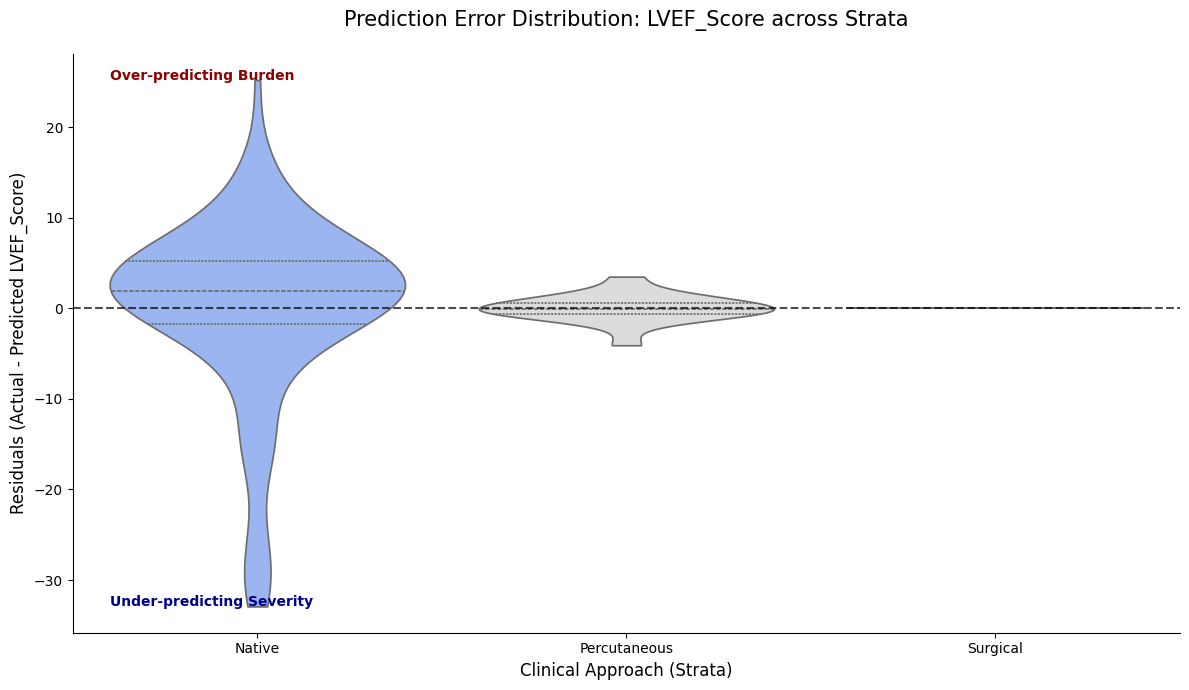

In [23]:
# Runs regressions using LVEF as a dependent variable
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_demographics = ['Age', 'Weight', 'Gender_Male', 'MBI']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
lvef_mismatch = stats.run_regression(y_var='LVEF_Score')

print("Residuals visualization to compare prediciton errors across intervention groups\n" + '-'*40)
viz.residual_distribution(lvef_mismatch, y_var='LVEF_Score')

In [24]:
# We will limit the regression's strata to Native only
config.regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
config.regression_demographics = ['Age', 'Weight', 'Gender_Male', 'MBI']
config.regression_lesions = ['Sev_MR', 'Sev_AR', 'Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'AFib_Present']
lvef_mismatch_native = stats.run_regression(y_var='LVEF_Score', strata='Native')


DEEP DIVE: LVEF_Score NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:             LVEF_Score   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.095
Date:                Sat, 03 Jan 2026   Prob (F-statistic):             0.0186
Time:                        21:41:29   Log-Likelihood:                -410.39
No. Observations:                 110   AIC:                             850.8
Df Residuals:                      95   BIC:                             891.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

<div style="padding: 15px; border: 1px solid #08306b; border-radius: 5px; background-color: #f7fbff; color: #08306b;"> <strong style="font-size: 1.2em;">Mechanical Analysis: Drivers of Systolic Function (LVEF)</strong>
    <p><b>1. The Native Baseline (The Compensation Phase):</b> The <b>Native</b> constant (<b>79.27</b>) is significantly higher than the intervention strata (~60). This suggests that many patients in the Native cohort are in a <i>hyperdynamic state</i>, where the heart over-contracts to compensate for severe regurgitation or stenosis. This is a fragile equilibrium, not a sign of health.</p>
    <p><b>2. Dilation vs. Performance:</b> <i>LVIDd</i> is the strongest negative predictor of function (<b>coef. -3.33, p = 0.017</b>). As the ventricle dilates, it loses the ability to maintain this hyperdynamic compensation, signaling a transition from "compensated" to "decompensated" heart failure.</p>
    <p><b>3. The Residual "Chimney" (Hyperdynamic Outliers):</b> The Native violin plot shows a narrow peak at <b>+25</b>. These are the most hyperdynamic patients in the cohort—those whose Ejection Fractions are extremely high despite significant disease. In a surgical triage context, these patients often require urgent intervention before the ventricle "burns out" and function drops.</p>
    <p><b>4. Post-Intervention Normalization:</b> The lower constants (60%) and tighter residuals in the <b>Surgical</b> and <b>Percutaneous</b> groups represent the achievement of a physiological "new normal." Once the mechanical lesion is fixed, the hyperdynamic stress is relieved, and the heart stabilizes at a lower, more sustainable contractile level.</p>
    <p><b>5. AFib & Remodeling:</b> The trending negative impact of <i>AFib</i> (<b>coef. -9.46, p = 0.07</b>) suggests that rhythm instability is one of the primary factors that "breaks" the hyperdynamic compensation, leading to a rapid decline in LVEF.</p>
</div>

ROC visualization for MBI
----------------------------------------


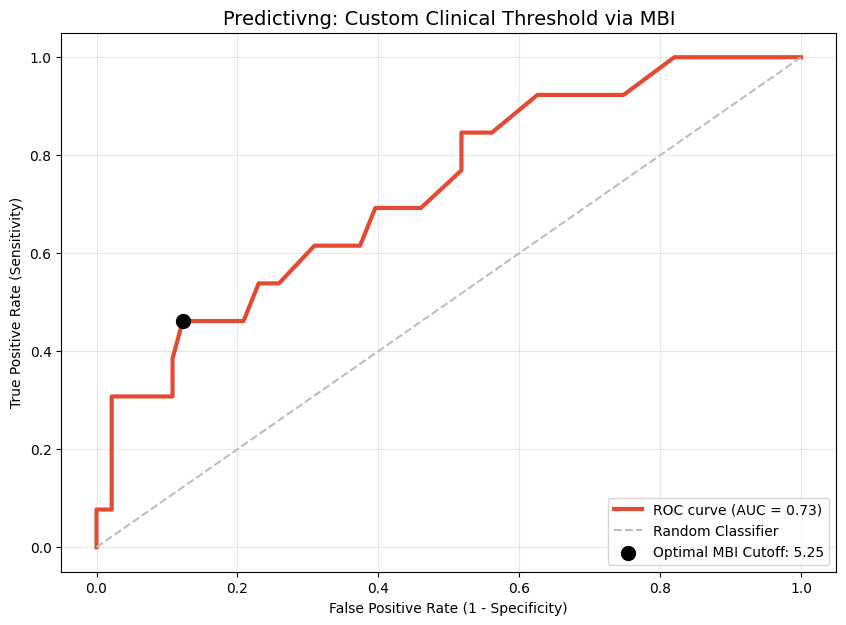

Analysis Complete: A value of MBI above 5.25 is the best predictor of patient complexity.

MBI Threshold Validation (> 5.25)
----------------------------------------
F1-Score:  0.288
Precision: 0.850 (Reliability: When MBI is high, is the patient actually sick?)
Recall:    0.173 (Sensitivity: Does MBI catch all the sick patients?)

Confusion matrix visualization
----------------------------------------


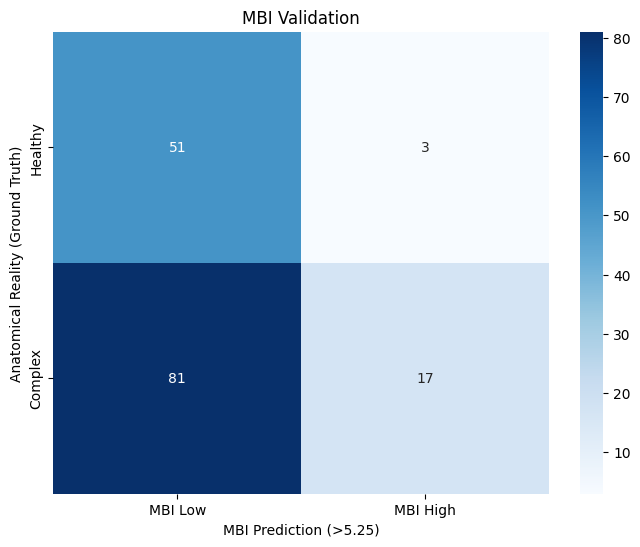

In [25]:
# ROC curve to predict high RVSP via MBI
stats.roc(predictor_col='MBI', target=(df['RVSP_Imputed'] > 60))

# Apply the MBI Cutoff (The Predictor)
mbi_cutoff = 5.25
df['MBI_Predicted_High'] = (df['MBI'] > mbi_cutoff).astype(int)
matrix_rvsp = stats.validate_predictor(mbi_cutoff)
viz.validate_vis(matrix_rvsp, 
                 'MBI Prediction (>5.25)', 'Anatomical Reality (Ground Truth)', 
                 'MBI Validation'
)

<div style="padding: 15px; border: 1px solid #003152; border-radius: 5px; background-color: #eff9ff; color: #003152;"> <strong style="font-size: 1.2em;">MBI-Driven Triage: From Baseline to Intervention</strong>
<p><b>1. The "Native Constant" (MBI 2.27):</b> Our statistical model identifies <b>2.27</b> as the cohort's baseline medication burden. A patient at this level represents the "standard" valvular case. Any value above this indicates a physiological demand exceeding the population average.</p>
<p><b>2. The Complexity Floor (MBI 4.0):</b> By setting the intervention bar at <b>4.0</b>, we move significantly beyond the 2.27 baseline into the <b>Top 25%</b> of cohort severity. This represents the point where baseline physiological constants are no longer sufficient, and the body requires significant pharmacological support.</p>
<p><b>3. Capturing the "Mixed" Signal:</b> The <b>Mixed Mitral</b> coefficient (2.22) is roughly equal to our <b>Native Constant</b> (2.27). In practice, an MBI of ~4.5 is the exact mathematical point where a baseline patient starts exhibiting the additive burden of a mixed-lesion phenotype. This validates our <b>4.0 Complexity Floor</b> as the entry point for high-priority cases.</p>
<p><b>4. The Critical Threshold (MBI 5.25):</b> At an MBI of <b>5.25</b> (more than double the baseline), we find the optimal predictor for <b>Critical Pulmonary Hypertension (RVSP > 60 mmHg)</b>. With a <b>Precision of 85%</b>, patients exceeding this score are highly likely to be in a state of advanced hemodynamic decompensation.</p>
<p><b>5. The "Intervention Window" (MBI 4.0 – 5.5):</b>
    <ul>
        <li><b>Zone 1: The "Stable/Monitor" Tier (MBI < 4.0):</b> Standard care. Patients near the <b>2.27 baseline</b> are likely stable and can be managed medically or deferred.</li>
        <li><b>Zone 2: The "Surgical Sweet Spot" (MBI 4.0 – 5.5):</b> This is the high-yield window. These patients have significant disease (MBI > 4.0) and include the critical PH cohort (MBI 5.25), but have not yet reached the level of pharmacological exhaustion.</li>
        <li><b>Zone 3: The "High-Risk / Palliative" Tier (MBI > 5.5):</b> The <b>High-Risk Ceiling</b>. Medication burden at this level suggests end-stage failure, requiring senior-level review for surgical futility.</li>
    </ul>
</p>
<p><b>6. Operational Impact:</b> This framework allows the intake team to "color-code" the patient queue, right at the registration desk.</p>
</div>

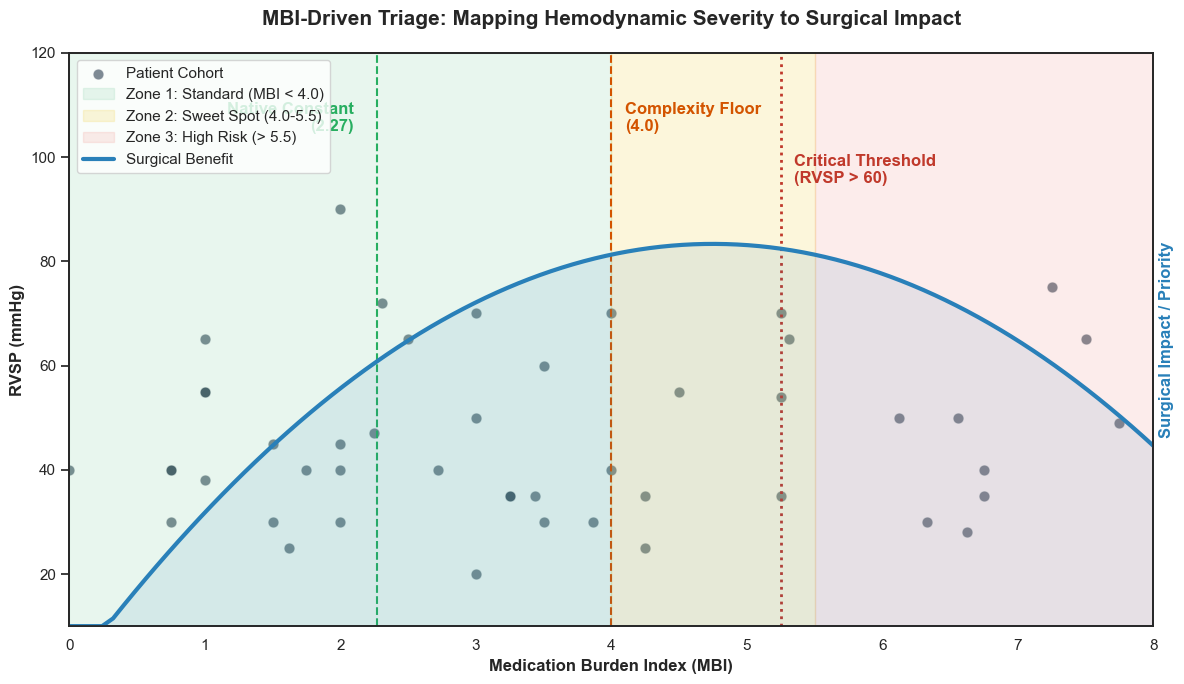

In [26]:
# 1. Plotting Configuration
sns.set_theme(style="white")
fig, ax1 = plt.subplots(figsize=(12, 7))

# PRIMARY AXIS: RVSP vs MBI Scatter
sns.scatterplot(data=df, x='MBI', y='RVSP', alpha=0.6, color='#2c3e50', s=60, ax=ax1, label='Patient Cohort')

# 2. Define Triage Zones (The Core Logic)
ax1.axvspan(0, 4.0, color='#27ae60', alpha=0.1, label='Zone 1: Standard (MBI < 4.0)')
ax1.axvspan(4.0, 5.5, color='#f1c40f', alpha=0.15, label='Zone 2: Sweet Spot (4.0-5.5)')
ax1.axvspan(5.5, 8.0, color='#e74c3c', alpha=0.1, label='Zone 3: High Risk (> 5.5)')

# 3. Clinical Threshold Markers
# Native Constant (2.27)
ax1.axvline(2.27, color='#27ae60', linestyle='--', linewidth=1.5)
ax1.text(2.1, 105, 'Native Constant\n(2.27)', color='#27ae60', fontweight='bold', ha='right')

# Complexity Floor (4.0)
ax1.axvline(4.0, color='#d35400', linestyle='--', linewidth=1.5)
ax1.text(4.1, 105, 'Complexity Floor\n(4.0)', color='#d35400', fontweight='bold')

# ROC-Derived Critical Threshold (5.25)
ax1.axvline(5.25, color='#c0392b', linestyle=':', linewidth=2)
ax1.text(5.35, 95, 'Critical Threshold\n(RVSP > 60)', color='#c0392b', fontweight='bold')

# 4. SECONDARY AXIS: The "U-Shape" Benefit Curve
ax2 = ax1.twinx()
x_curve = np.linspace(0, 8, 100)
# Parabolic benefit centered on the Sweet Spot (~4.75)
benefit_curve = -0.5 * (x_curve - 4.75)**2 + 10 
benefit_curve = np.clip(benefit_curve, 0, 10)

ax2.plot(x_curve, benefit_curve, color='#2980b9', linewidth=3, label='Surgical Benefit')
ax2.fill_between(x_curve, 0, benefit_curve, color='#2980b9', alpha=0.1)

# 5. Styling & Labels
ax1.set_xlabel('Medication Burden Index (MBI)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RVSP (mmHg)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Surgical Impact / Priority', fontsize=12, fontweight='bold', color='#2980b9')
plt.title('MBI-Driven Triage: Mapping Hemodynamic Severity to Surgical Impact', fontsize=15, pad=20, fontweight='bold')

# Legend and limits
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True)
ax1.set_xlim(0, 8)
ax1.set_ylim(10, 120)
ax2.set_ylim(0, 15)
ax2.set_yticks([]) # Qualitative axis

plt.tight_layout()
plt.show()

In [27]:
# PHASE 6: Executive Summary (Final Clinical Insights)
# ==========================================================
print(f"\nPHASE 6: EXECUTIVE SUMMARY & TRIAGE LOGIC (BRIGADE PROTOCOL)\n{'='*70}")

# 1. Final Model Benchmarks
# ----------------------------------------------------------
# The MBI > 4.0 cutoff is based on the 2.27 Native Constant + Mixed Mitral Coef (2.22)
total = len(df)
native_cohort = df[df['Approach'] == 'Native']
avg_mbi_native = native_cohort['MBI'].mean()
high_mbi_n = (df['MBI'] >= 4.0).sum()

# 2. Logic for U-Shaped Triage Filtering (Updated Findings)
# ----------------------------------------------------------

# ZONE 1: THE "UNDER-TREATED" SILENT NATIVE (Priority 1)
# These are the Mismatch cases (Low meds but physiological strain)
# Identifying patients with MBI below the Native Constant (2.27) but significant RVSP or MS MG
silent_native_mask = (
    (df['Approach'] == 'Native') & 
    (df['MBI'] <= 2.5) & 
    ((df['RVSP_Imputed'] > 50) | (df['MS MG (mmHg)_Imputed'] > 10))
)
silent_n = silent_native_mask.sum()

# ZONE 2: THE "SURGICAL SWEET SPOT" (Priority 2)
# MBI between 4.0 and 5.5. Focusing on the Hyperdynamic Paradox (EF > 70)
# These hearts are compensating but at high risk of dilation burnout.
sweet_spot_mask = (
    (df['Approach'] == 'Native') &
    (df['MBI'] >= 4.0) & (df['MBI'] < 5.5)
)
sweet_spot_n = sweet_spot_mask.sum()

# ZONE 3: THE "MIXED MITRAL" ACCELERATOR
# Regardless of MBI, Mixed Mitral carries a Coef of 2.22 (The strongest predictor)
mixed_mitral_mask = (df['Mixed_Mitral'] == 1) & (df['Approach'] == 'Native')
mixed_n = mixed_mitral_mask.sum()

# ZONE 4: HIGH-RISK / PALLIATIVE (The "Chimney" Group)
# Extreme MBI (> 6.0) and extreme RVSP residuals (> 80)
palliative_mask = (df['MBI'] >= 5.5) | (df['RVSP_Imputed'] > 60)
palliative_n = palliative_mask.sum()

# 3. Output Display
# ----------------------------------------------------------
print(f"COHORT METRICS:")
print(f"  - Total Patients Analyzed:    {total}")
print(f"  - Cohort Constant Baseline:   2.27 (Weighted MBI)")
print(f"  - Avg Native MBI:             {avg_mbi_native:.2f}")
print(f"  - High Complexity (MBI > 4):  {high_mbi_n} cases")

print(f"\nBRIGADE TRIAGE LOGIC (U-SHAPE FILTERING):")
print("-" * 60)
print(f"  [PRIORITY 1] SILENT NATIVES:        {silent_n}")
print(f"               (MBI < 2.5 but RVSP > 50. High risk of sudden decompensation.)")

print(f"  [PRIORITY 2] SURGICAL SWEET SPOT:   {sweet_spot_n}")
print(f"               (MBI 4.0-5.5. Optimal ROI for intervention.)")

print(f"  [CRITICAL]   MIXED MITRAL PHENOTYPE: {mixed_n}")
print(f"               (Strongest Predictor: Coef 2.22. Requires Priority.)")

print(f"  [CAUTION]    HIGH-RISK/PALLIATIVE:   {palliative_n}")
print(f"               (MBI > 5.5 or RVSP > 60. 'Chimney' Outliers - Surgical futility evaluation.)")

print(f"\nTECHNICAL NOTE:")
print(f"MBI Weights Applied: Loop Diuretics/Vasodilators (3.0), RAASi/BB/MRA (2.0), \nMaintenance (1.0). R-Squared of Final Integrated Model: 0.425")


PHASE 6: EXECUTIVE SUMMARY & TRIAGE LOGIC (BRIGADE PROTOCOL)
COHORT METRICS:
  - Total Patients Analyzed:    152
  - Cohort Constant Baseline:   2.27 (Weighted MBI)
  - Avg Native MBI:             3.03
  - High Complexity (MBI > 4):  39 cases

BRIGADE TRIAGE LOGIC (U-SHAPE FILTERING):
------------------------------------------------------------
  [PRIORITY 1] SILENT NATIVES:        8
               (MBI < 2.5 but RVSP > 50. High risk of sudden decompensation.)
  [PRIORITY 2] SURGICAL SWEET SPOT:   19
               (MBI 4.0-5.5. Optimal ROI for intervention.)
  [CRITICAL]   MIXED MITRAL PHENOTYPE: 5
               (Strongest Predictor: Coef 2.22. Requires Priority.)
  [CAUTION]    HIGH-RISK/PALLIATIVE:   26
               (MBI > 5.5 or RVSP > 60. 'Chimney' Outliers - Surgical futility evaluation.)

TECHNICAL NOTE:
MBI Weights Applied: Loop Diuretics/Vasodilators (3.0), RAASi/BB/MRA (2.0), 
Maintenance (1.0). R-Squared of Final Integrated Model: 0.425


In [28]:
print(f"\nPHARMACOLOGICAL DRIVERS SUMMARY:")
print("-" * 40)
# Showing top medication drivers as previously calculated
for category, burden in config.class_weights.items():
    # Find the dominant drug in this category from your df_comp
    top_drug = mbi_decomposed[mbi_decomposed['Medication_Class'] == category].nlargest(1, 'Burden_Score')
    drug_name = top_drug['Specific_Drug'].values[0]
    drug_pct = top_drug['Percentage_of_Class'].values[0]
    print(f"  - {category:<25} | Burden: {burden:>5.1f} (Lead: {drug_name} {drug_pct:.1f}%)")

print("\nDISEASE PREVALENCE:")
display(prevalence.head(10))


PHARMACOLOGICAL DRIVERS SUMMARY:
----------------------------------------
  - Diuretics_Loop            | Burden:   3.0 (Lead: Furosemide 100.0%)
  - Pulmonary_Vasodilators    | Burden:   3.0 (Lead: Sildenafil 77.7%)
  - RAAS_Inhibitors           | Burden:   2.0 (Lead: Losartan 55.3%)
  - SGLT2_Inhibitors          | Burden:   2.0 (Lead: Dapaglifozin 73.5%)
  - Diuretics_Other           | Burden:   2.0 (Lead: Spironolactone 95.3%)
  - Beta_Blockers             | Burden:   2.0 (Lead: Carvedilol 49.1%)
  - Rate_Rhythm_Control       | Burden:   1.0 (Lead: Digoxin 95.7%)
  - Anticoagulants_Antiplatelets | Burden:   1.0 (Lead: Aspirin 47.5%)
  - Calcium_Channel_Blockers  | Burden:   1.0 (Lead: Amlodipine 84.4%)
  - Anti_Ischemic_Other       | Burden:   1.0 (Lead: Trimetazidine 67.2%)
  - Lipid_Lowering            | Burden:   0.5 (Lead: Simvastatin 46.2%)
  - Metabolic_Endocrine       | Burden:   0.5 (Lead: Levothyroxine 54.0%)

DISEASE PREVALENCE:


,Patient Count,Prevalence (%)
Diagnosis,,
Mitral stenosis,49,32.2
Aortic stenosis,34,22.4
Secundum atrial septal defect,22,14.5
Mitral regurgitation,19,12.5
Pulmonary hypertension,15,9.9
Aortic regurgitation,15,9.9
Surgical aortic valve replacement,14,9.2
Bicuspid aortic valve,12,7.9
Mitral valve percutaneous valvuloplasty,11,7.2
